In [1]:
# Parameters
system_name = "J1620+1203"
filter = "F160W"
r1 = 4.2
dx_outer = 0.4
dy_outer = 0.35
dx_center = 0.2
dy_center = 0.1
x1 = 40
y1 = 41
x2 = 44
y2 = 46
x3 = 67
y3 = 65
use_center_mask = False

In [2]:
# Standard Python imports
import os
import copy
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Astropy imports
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ImageNormalize, LogStretch
import astropy.io.fits as pyfits

# Lenstronomy imports
import lenstronomy
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import kernel_util
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Workflow.fitting_sequence import FittingSequence

# Prepare F814W Data

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_69521/2108883408.py:21: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


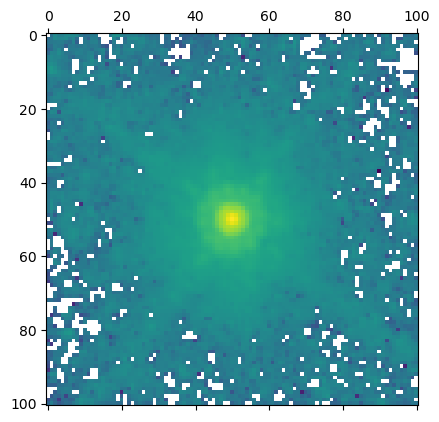

In [ ]:
# load F814W PSF data
psf_file = f'../../cutout_data/{system_name}/F814W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

variance = np.loadtxt(f'cutout_data/{system_name}/F814W/psf_variance.txt')

var_array = np.array(variance)

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf1 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              'psf_variance_map': var_array
              }
psf_class = PSF(**kwargs_psf1)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [ ]:
# Open the FITS file and extract the header
filename = f'../../joint_modeling/{system_name}/{system_name}_F814W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data1 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics1 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# Prepare F475X Data

/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_69521/2085264579.py:19: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


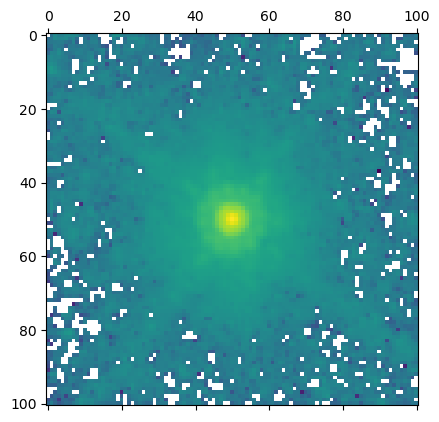

In [ ]:
# load F475X PSF data
psf_file = f'../../cutout_data/{system_name}/F475X/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

variance = np.loadtxt(f'cutout_data/{system_name}/F475X/psf_variance.txt')

var_array = np.array(variance)

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf2 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              #'psf_variance_map': var_array
              }
kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

In [ ]:
# Open the FITS file and extract the header
filename = f'../../joint_modeling/{system_name}/{system_name}_F475X_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.04  # size of UVIS pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data2 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics2 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# Prepare F160W Data

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_69521/975544075.py:21: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kernel_psf_class))


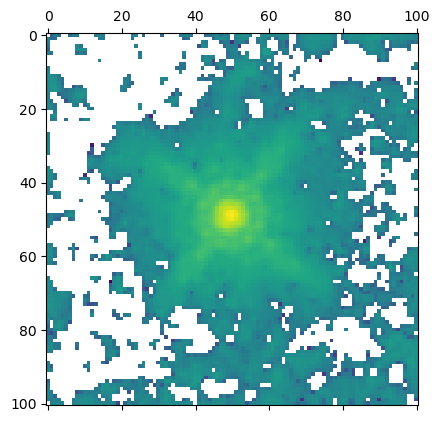

In [ ]:
# load F475X PSF data
psf_file = f'../../cutout_data/{system_name}/F160W/outputs/full_PSF.fits'

kernel = pyfits.getdata(psf_file)
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 301

variance = np.loadtxt(f'cutout_data/{system_name}/F160W/psf_variance.txt')

var_array = np.array(variance)

kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf3 = {'psf_type': psf_type, 'kernel_point_source': kernel_cut, 
              'point_source_supersampling_factor': 3, 
              'psf_variance_map': var_array
              }
psf_class = PSF(**kwargs_psf3)

kernel_psf_class = psf_class.kernel_point_source

plt.matshow(np.log10(kernel_psf_class))
plt.show()

Initial guess for theta_E: 1.4449913494550755


/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_69521/3870906009.py:63: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')


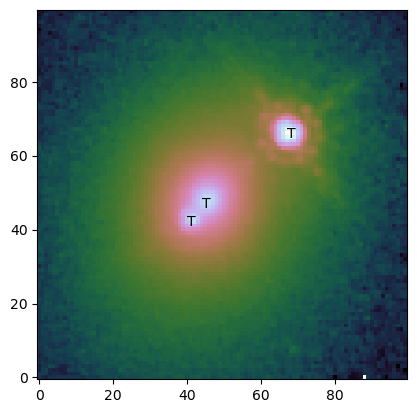

In [12]:
# Open the FITS file and extract the header
filename = f'../../cutout_data/{system_name}/F160W/{system_name}_F160W_cutout.fits'

with fits.open(filename) as hdul:
    header = hdul[0].header
    image_data = hdul[0].data 

# read out matrix elements and convert them in units of arc seconds
CD1_1 = header['CD1_1'] * 3600  # change in arc sec per pixel d(ra)/dx
CD1_2 = header['CD1_2'] * 3600
CD2_1 = header['CD2_1'] * 3600
CD2_2 = header['CD2_2'] * 3600

# generate pixel-to-coordinate transform matrix and its inverse
pix2coord_transform_undistorted = np.array([[CD1_1, CD1_2], [CD2_1, CD2_2]])
det = CD1_1*CD2_2 - CD1_2*CD2_1
coord2pix_transform_undistorted = np.array([[CD2_2, -CD1_2], [-CD2_1, CD1_1]])/det

# as an example, we set the coordinate zero point in the center of the image and compute 
# the coordinate at the pixel (0,0) at the edge of the image

# read out pixel size of image
nx = header.get('NAXIS1')
ny = header.get('NAXIS2')
x_c = int(nx / 2)
y_c = int(ny / 2)

# compute RA/DEC relative shift between the edge and the center of the image
dra, ddec = pix2coord_transform_undistorted.dot(np.array([x_c, y_c]))
# set edge of the image such that the center has RA/DEC = (0,0)
ra_at_xy_0, dec_at_xy_0 = -dra, -ddec

# import the PixelGrid() class #

deltaPix = 0.08  # size of IR pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': nx, 'ny': ny,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates

# set up data class
kwargs_data3 = {'image_data': image_data,
               'background_rms': header['BACK_RMS'],
               'exposure_time': header['EXPTIME'],
               'ra_at_xy_0': ra_at_xy_0,  
               'dec_at_xy_0': dec_at_xy_0,
               'transform_pix2angle': transform_pix2angle} 

kwargs_numerics3 = {'supersampling_factor': 1, 'supersampling_convolution': False,
                   'point_source_supersampling_factor': 3}

# display science image and obtain coordinates of point source and lens centers
plt.annotate('T', [x1,y1], color='black')
plt.annotate('T', [x2,y2], color='black')
plt.annotate('T', [x3,y3], color='black')

plt.imshow(np.log10(image_data), origin='lower', cmap='cubehelix')

im1 = pixel_grid.map_pix2coord(x1, y1)

lens_pos = pixel_grid.map_pix2coord(x2,y2)

im2 = pixel_grid.map_pix2coord(x3,y3)

# lens coordinates
lens_center_x, lens_center_y = lens_pos[0], lens_pos[1]
# image coordinates #
im1_x, im1_y = im1[0], im1[1]
im2_x, im2_y = im2[0], im2[1]

# calculate the initial guess for theta_E as half the image separation
einstein_rad = np.sqrt((im2_x - im1_x)**2 + (im2_y - im1_y)**2) / 2
print(f'Initial guess for theta_E: {einstein_rad}')

# set up point source and lens positions
theta_ra = np.array([im1_x, im2_x])
theta_dec = np.array([im1_y, im2_y])

plt.show()

In [13]:
# model parameters, applicaple for both bands

lens_model_list = ['EPL', 'SHEAR']

lens_light_model_list = ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

source_model_list = ['SERSIC_ELLIPSE']

point_source_list = ['LENSED_POSITION']

# set up model arguments

kwargs_model = {'lens_model_list': lens_model_list,
                               'lens_light_model_list': lens_light_model_list,
                               'point_source_model_list': point_source_list,
                               #'source_light_model_list': source_model_list
                               }


kwargs_constraints = {'num_point_source_list': [2],
                              'joint_lens_with_light': [[0, 0, ['center_x', 'center_y']]],
                              'joint_lens_light_with_lens_light': [[0, 1, ['center_x', 'center_y']]],
                              #'joint_source_with_point_source': [[0, 0]],
                              }

kwargs_likelihood = {'check_bounds': True,
                     #'image_likelihood_mask_list': [mask_img],
                            #'image_position_uncertainty': 0.004,
                      'source_position_likelihood': True,                              
                      'source_position_tolerance': 0.001
                              }

image_band1 = [kwargs_data1, kwargs_psf1, kwargs_numerics1]
image_band2 = [kwargs_data2, kwargs_psf2, kwargs_numerics2]
image_band3 = [kwargs_data3, kwargs_psf3, kwargs_numerics3]
multi_band_list = [image_band3, image_band1, image_band2]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}

In [14]:
# initial guess of non-linear parameters
kwargs_lens_init = [{'theta_E': einstein_rad, 'gamma': 2., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y},
                    {'gamma1': 0., 'gamma2': 0., 'ra_0': 0, 'dec_0': 0}]
kwargs_lens_light_init = [{'R_sersic': 1., 'n_sersic': 2., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y},
                          {'R_sersic': 2., 'n_sersic': 4., 'e1': 0, 'e2': 0, 'center_x': lens_center_x, 'center_y': lens_center_y}]

kwargs_source_init = [{'R_sersic': 0.3, 'n_sersic': 1., 'e1': 0., 'e2': 0., 'center_x': lens_center_x, 'center_y': lens_center_y}]
kwargs_ps_init = [{'ra_image': theta_ra, 'dec_image': theta_dec}]

# initial spread in parameter estimation #
kwargs_lens_sigma = [{'theta_E': 0.2, 'gamma': .5, 'e1': .5, 'e2': .5, 'center_x': 0.1, 'center_y': 0.1},
                     {'gamma1': .1, 'gamma2': .1}]
kwargs_lens_light_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1},
                           {'R_sersic': .5, 'n_sersic': .5, 'e1': .1, 'e2': .1, 'center_x': .1, 'center_y': 0.1}]
kwargs_source_sigma = [{'R_sersic': .5, 'n_sersic': .5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': .1}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 2, 'dec_image': [0.02] * 2}]

# hard bound lower limit in parameter space #
kwargs_lower_lens = [{'theta_E': 0.01, 'gamma': 1., 'e1': -0.15, 'e2': -0.15, 'center_x': -10., 'center_y': -10},
                     {'gamma1': -0.3, 'gamma2': -0.3}]
kwargs_lower_lens_light = [{'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10},
                           {'R_sersic': 0.001, 'n_sersic': 0.5, 'e1': -0.15, 'e2': - 0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_source = [{'R_sersic': 0.001, 'n_sersic': .5, 'e1': -0.15, 'e2': -0.15, 'center_x': -10, 'center_y': -10}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones_like(theta_ra), 'dec_image': -10 * np.ones_like(theta_dec)}]

# hard bound upper limit in parameter space #
kwargs_upper_lens = [{'theta_E': 10, 'gamma': 3., 'e1': 0.15, 'e2': 0.15, 'center_x': 10., 'center_y': 10},
                     {'gamma1': 0.3, 'gamma2': 0.3}]
kwargs_upper_lens_light = [{'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10},
                           {'R_sersic': 10, 'n_sersic': 6., 'e1': 0.15, 'e2': 0.15, 'center_x': 10, 'center_y': 10}]
kwargs_upper_source = [{'R_sersic': .5, 'n_sersic': 1.5, 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10}]
kwargs_upper_ps = [{'ra_image': 10 * np.ones_like(theta_ra), 'dec_image': 10 * np.ones_like(theta_dec)}]


lens_params = [kwargs_lens_init, kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 #'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/LensModel/Profiles/epl.py:297: RuntimeWarning: invalid value encountered in divide
  R_omega = Z * hyp2f1(1, t / 2, 2 - t / 2, -(1 - q) / (1 + q) * (Z / Z.conj()))
  0%|          | 0/100 [00:51<?, ?it/s]
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


-11.936295249511975 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  11.936295249511979


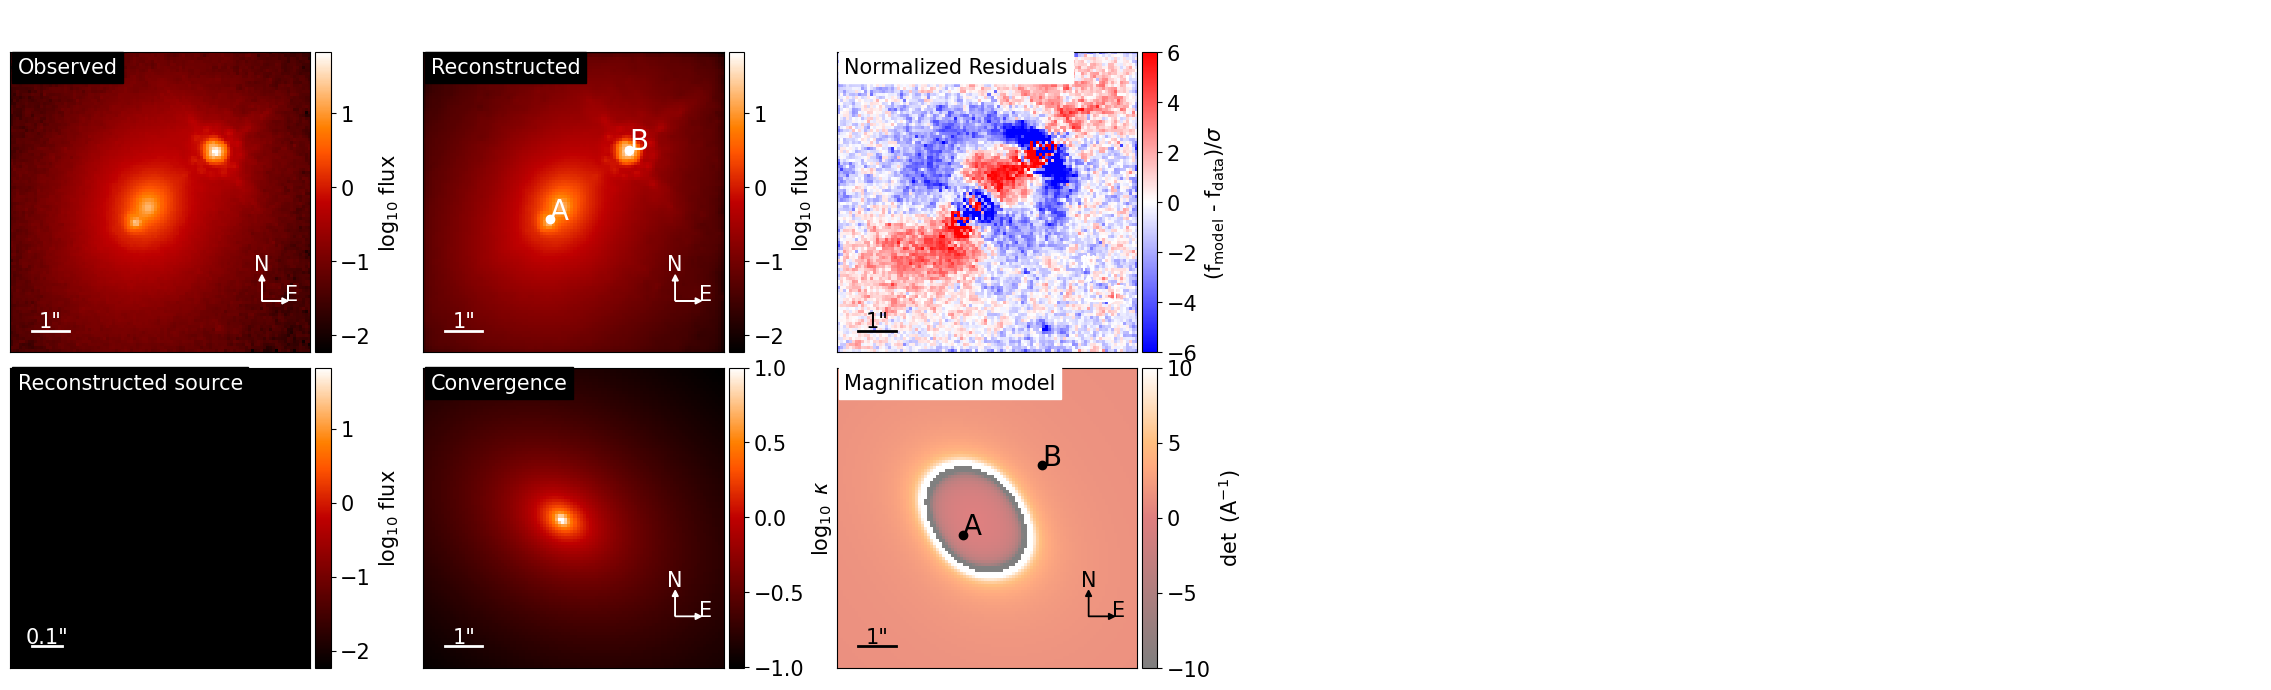

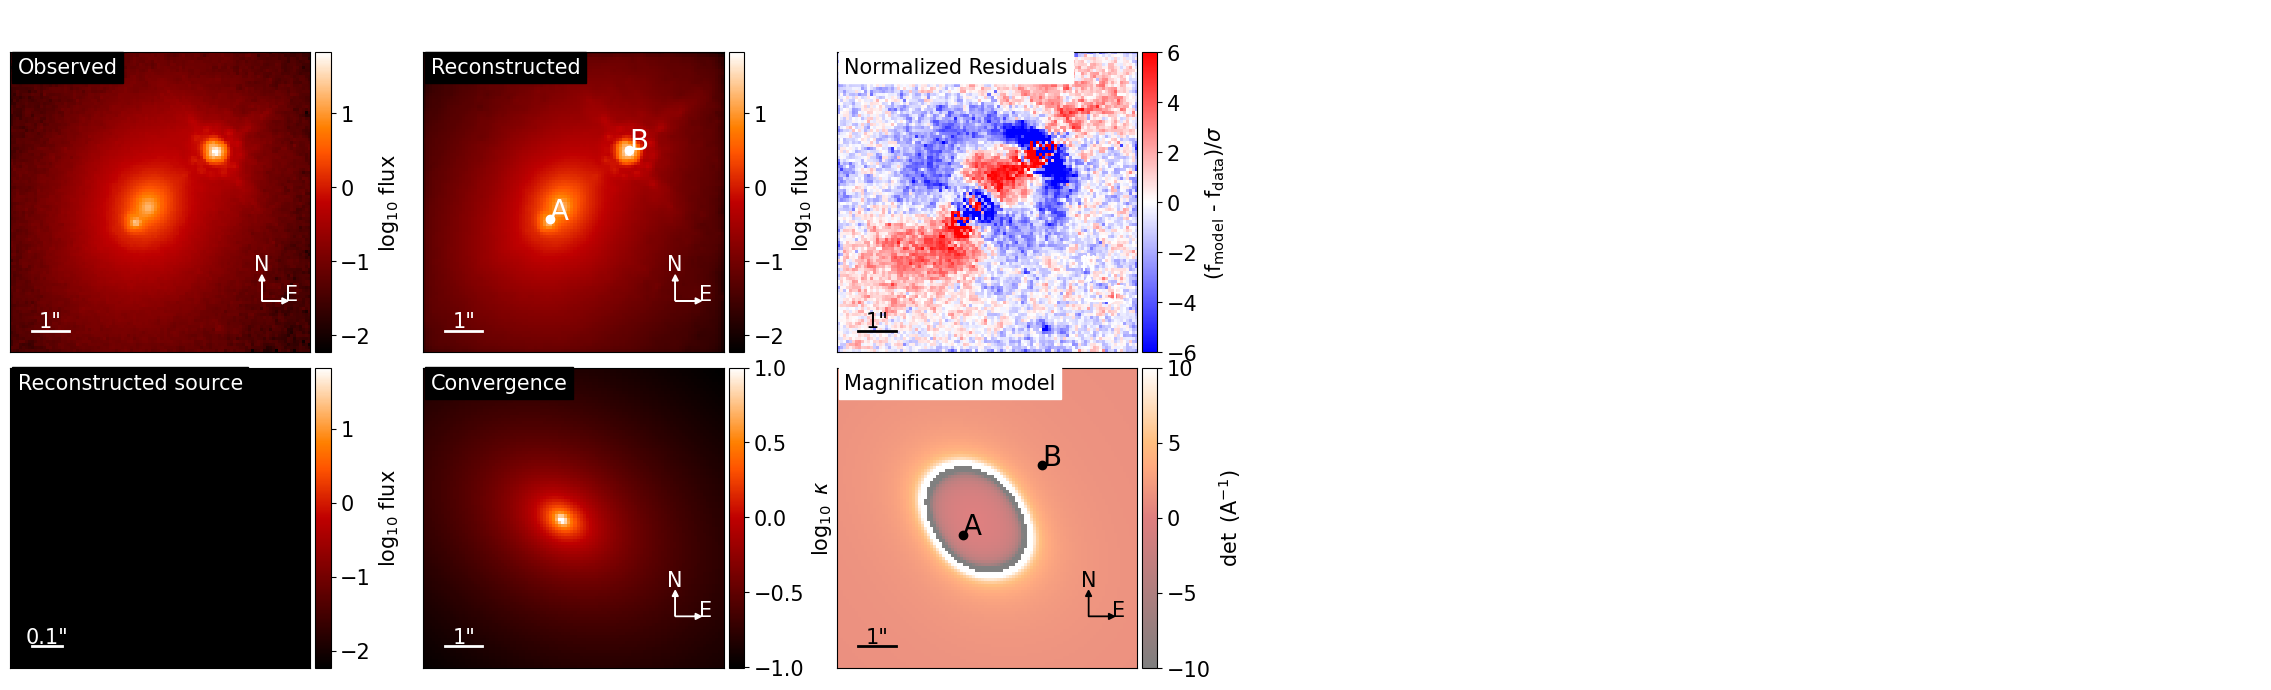

In [15]:
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = False)

fitting_kwargs_list = [
    ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, False, False]}}], 
    ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO first band
    ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

filter_index = 0
single_band = [multi_band_list[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f

  0%|          | 0/100 [01:16<?, ?it/s]


-863.2601100090461 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.4528989455847
reduced chi^2 of data  1 =  1107.5917817063498
reduced chi^2 of data  2 =  832.3802410776062


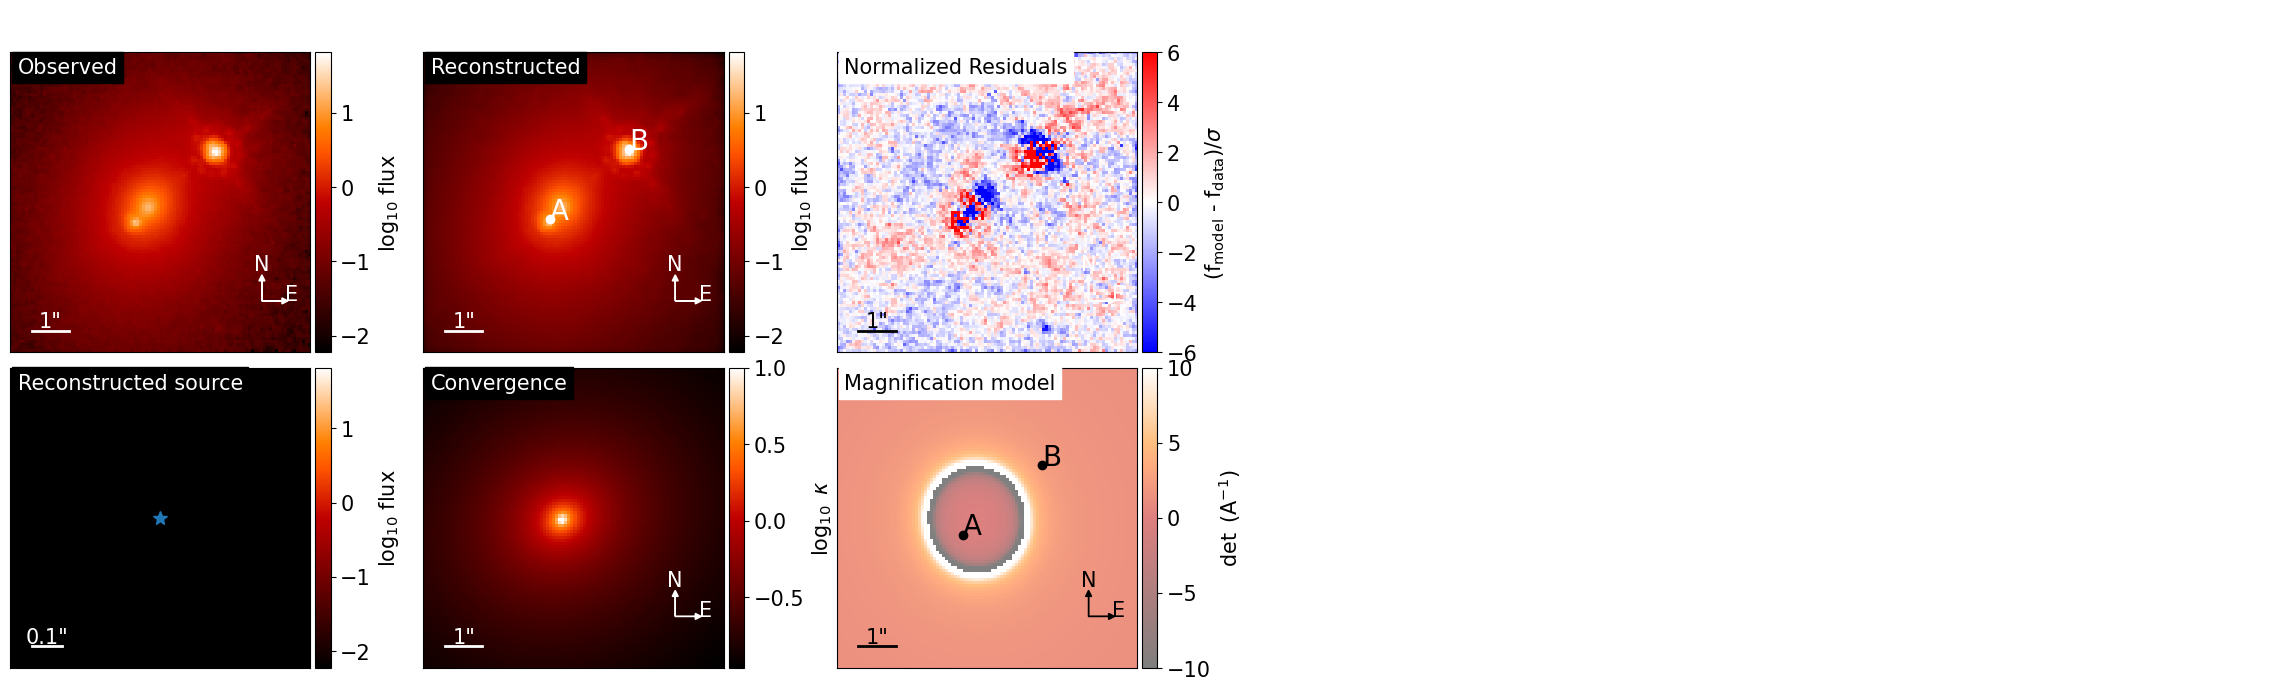

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


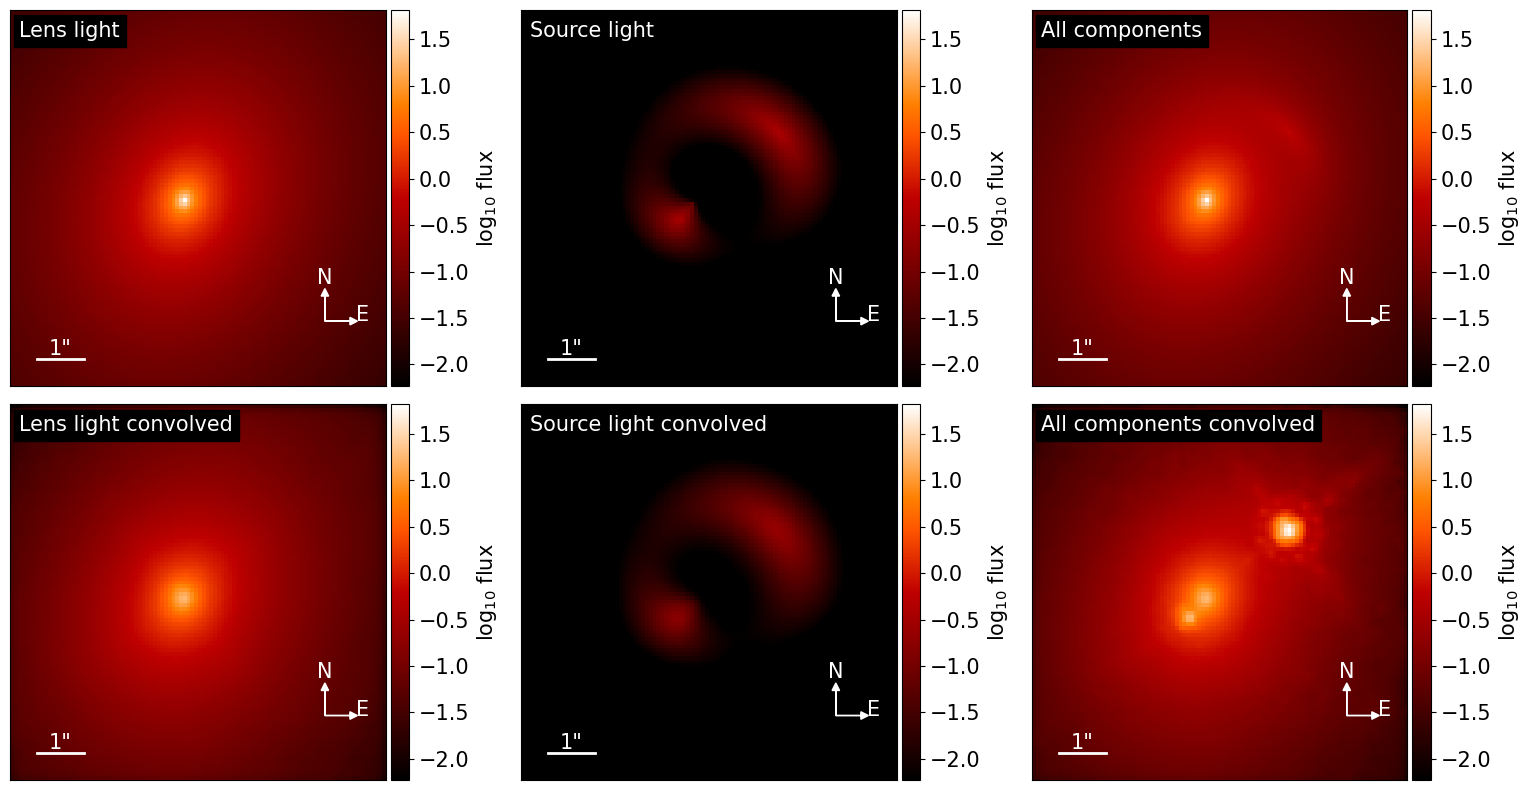

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


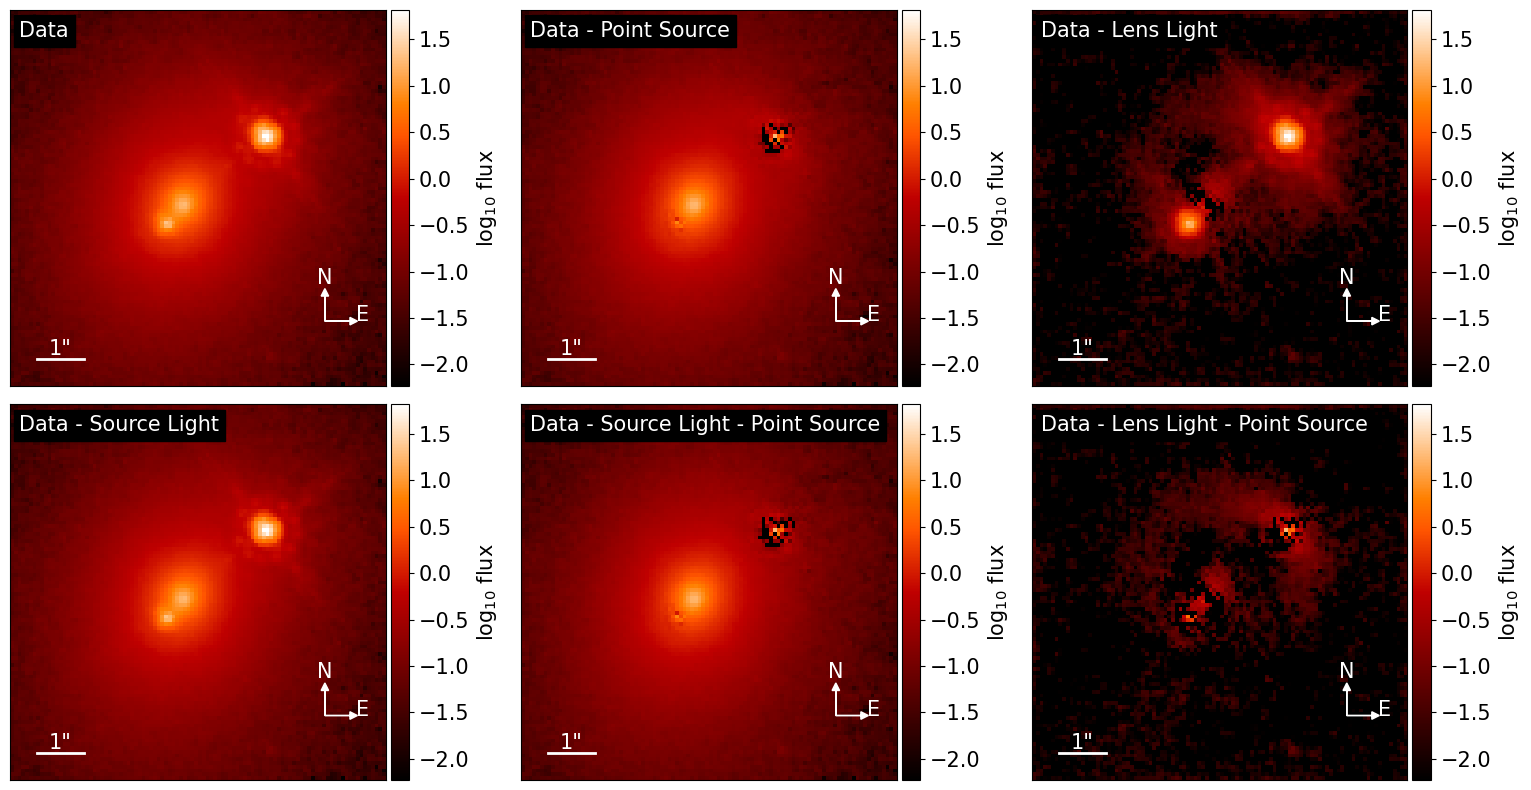

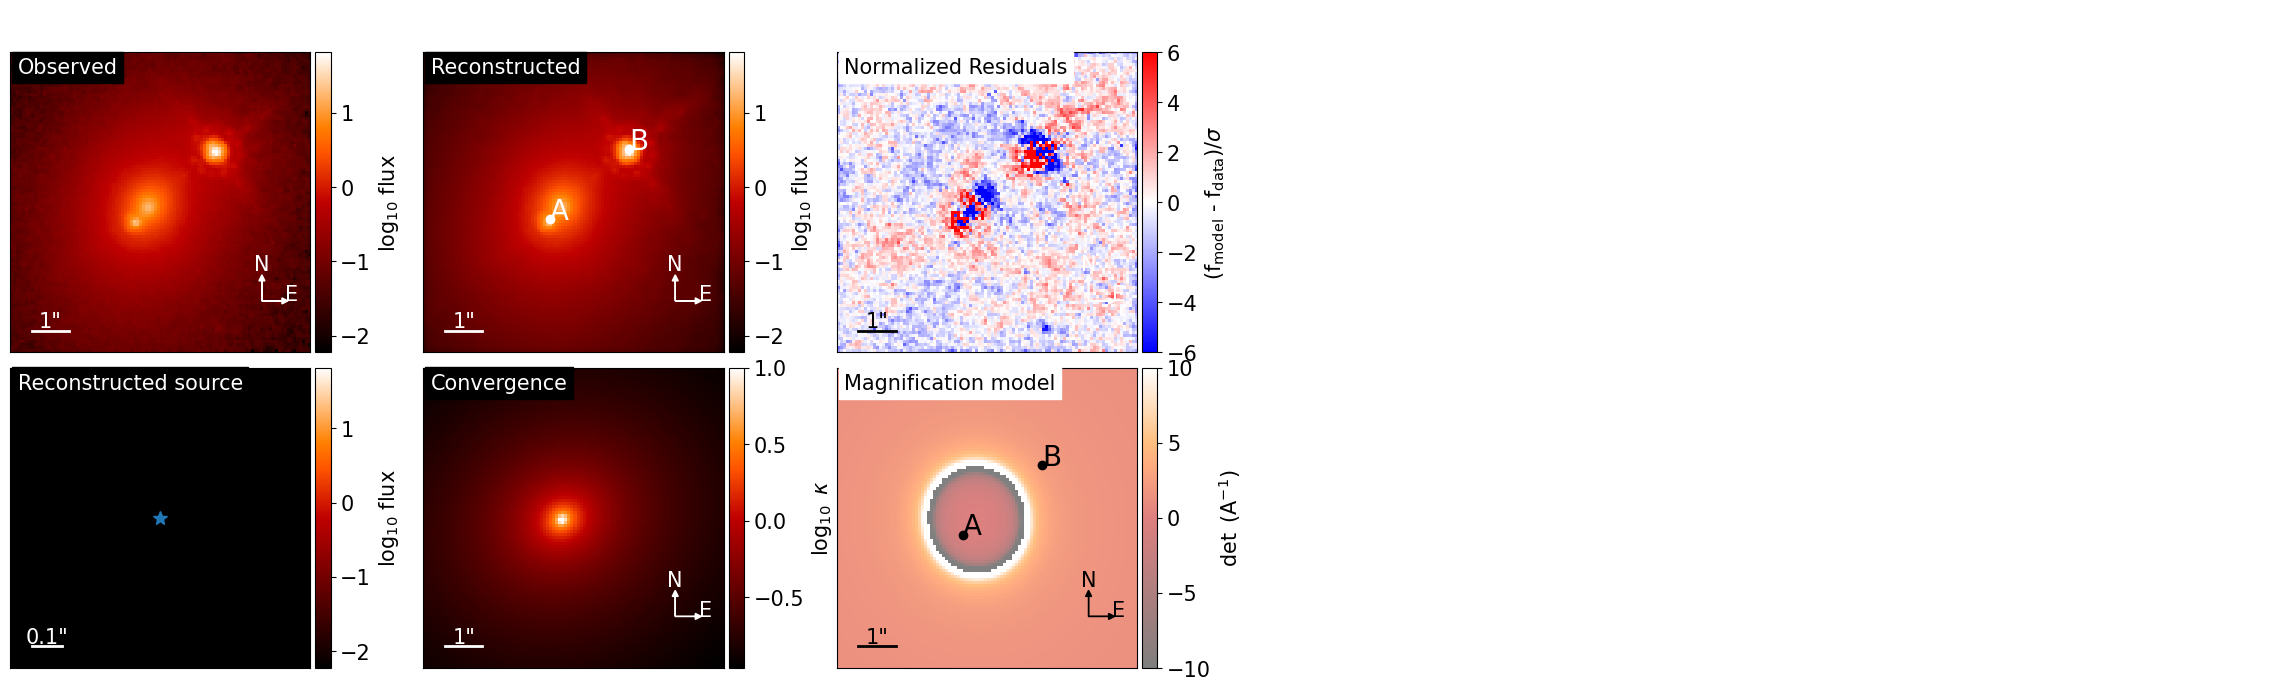

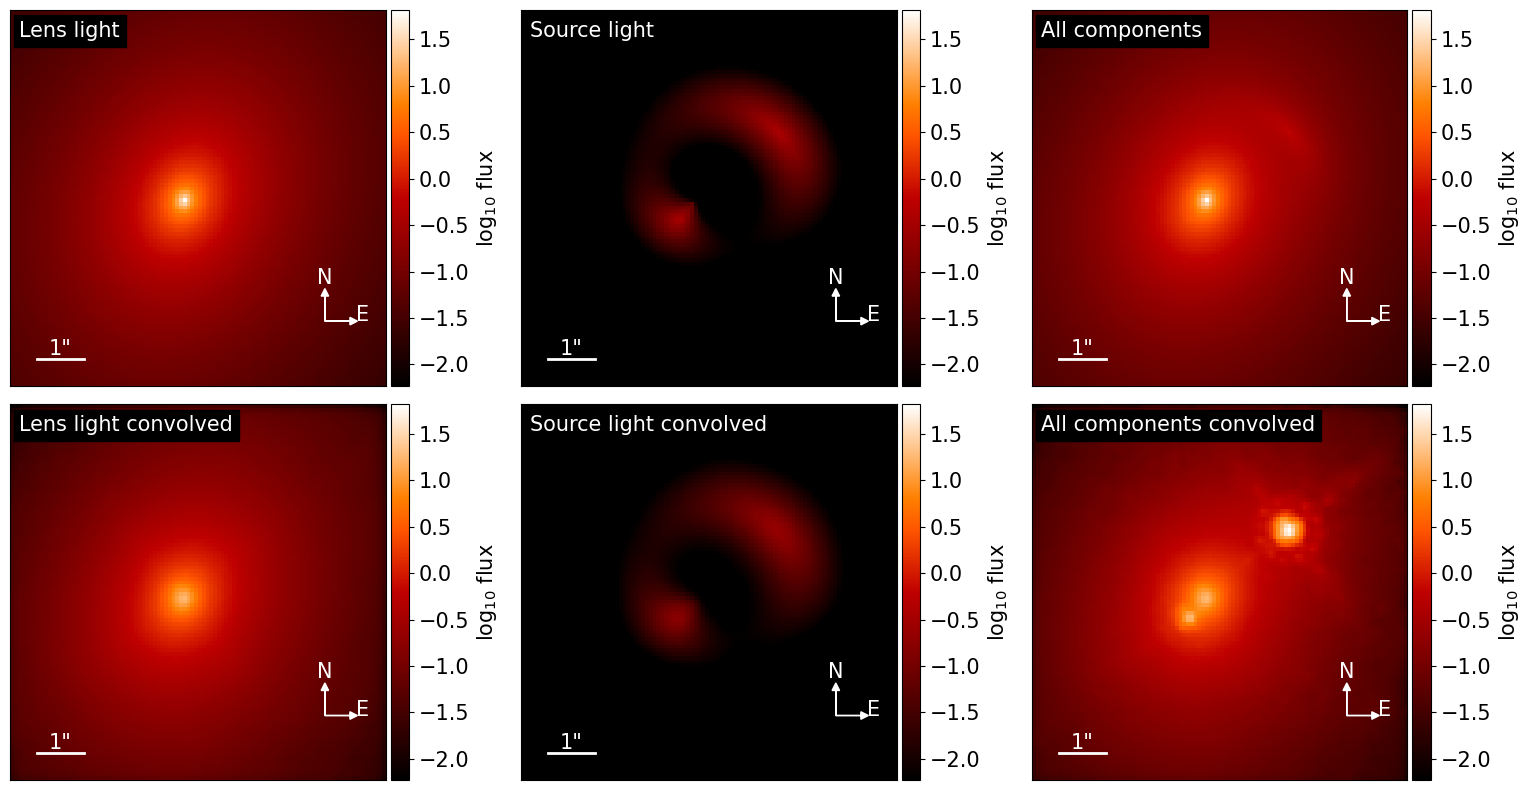

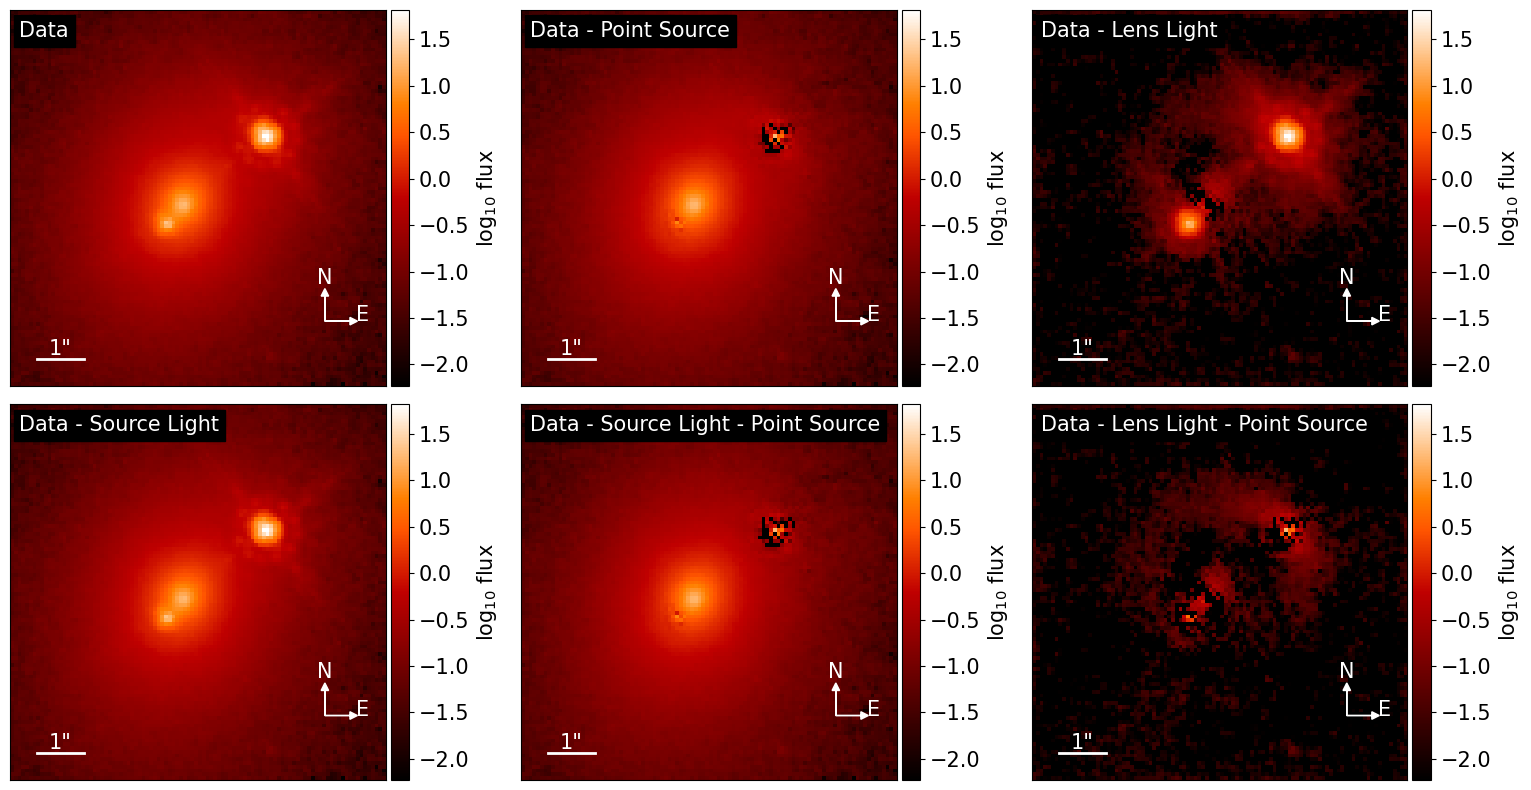

In [ ]:
# add source light model arguments and update
# initial guesses to be results of previous run
kwargs_model.update({'source_light_model_list': source_model_list})

kwargs_constraints.update({'joint_source_with_point_source': [[0, 0]]})

lens_params = [kwargs_result['kwargs_lens'], kwargs_lens_sigma, [{'gamma': 2}, {'ra_0': 0, 'dec_0': 0}], kwargs_lower_lens, kwargs_upper_lens]
lens_light_params = [kwargs_result['kwargs_lens_light'], kwargs_lens_light_sigma, [{}, {}], kwargs_lower_lens_light, kwargs_upper_lens_light]
source_params = [kwargs_source_init, kwargs_source_sigma, [{}], kwargs_lower_source, kwargs_upper_source]
ps_params = [kwargs_result['kwargs_ps'], kwargs_ps_sigma, [{}], kwargs_lower_ps, kwargs_upper_ps]

kwargs_params = {'lens_model': lens_params,
                 'source_model': source_params,
                'lens_light_model': lens_light_params,
                'point_source_model': ps_params}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, verbose = True)

# try to fit the IR reference band as best we can before aligning images

fitting_kwargs_list = [['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()
multi_band_list = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
f, axes = modelPlot.plot_main()
display(f)
f, axes = modelPlot.plot_separate()
display(f)
f, axes = modelPlot.plot_subtract_from_data_all()
display(f)


iteration of step 0 gave best reconstruction.
log likelihood before: -47264.49472792349 and log likelihood after: -47264.49472792349


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:138: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin="lower", **kwargs)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),


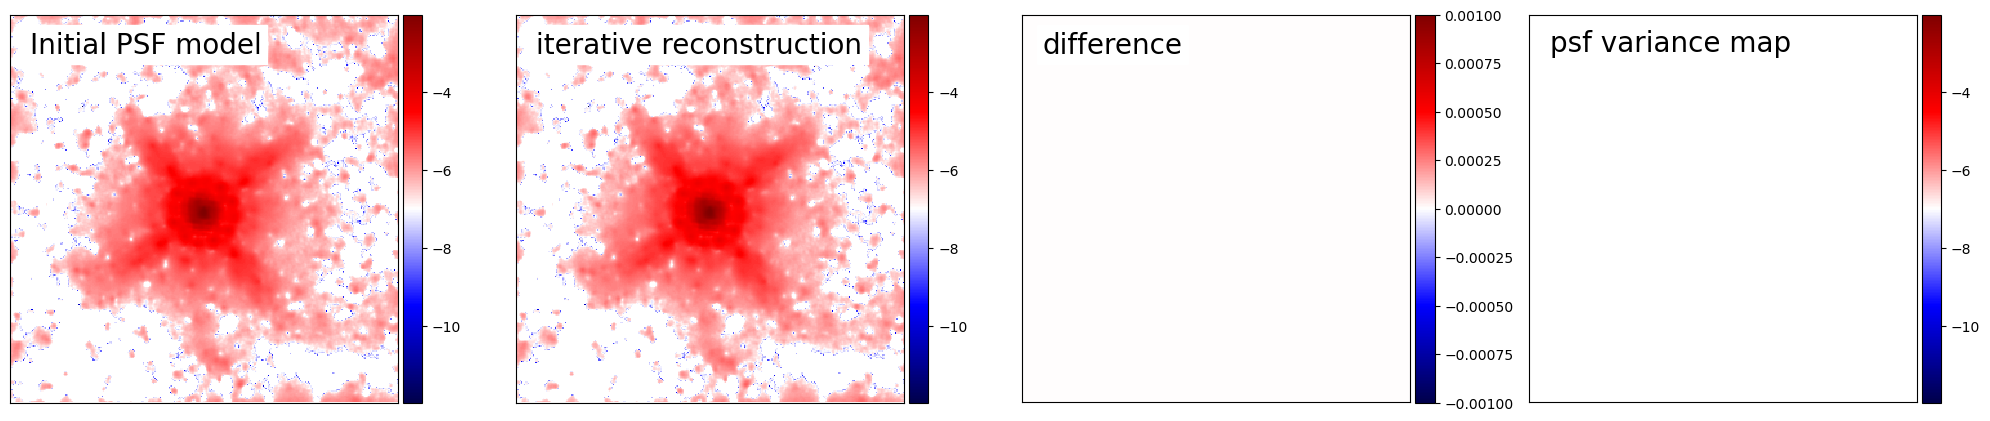

-863.2601100090461 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.4528989455847
reduced chi^2 of data  1 =  1107.5917817063498
reduced chi^2 of data  2 =  832.3802410776062


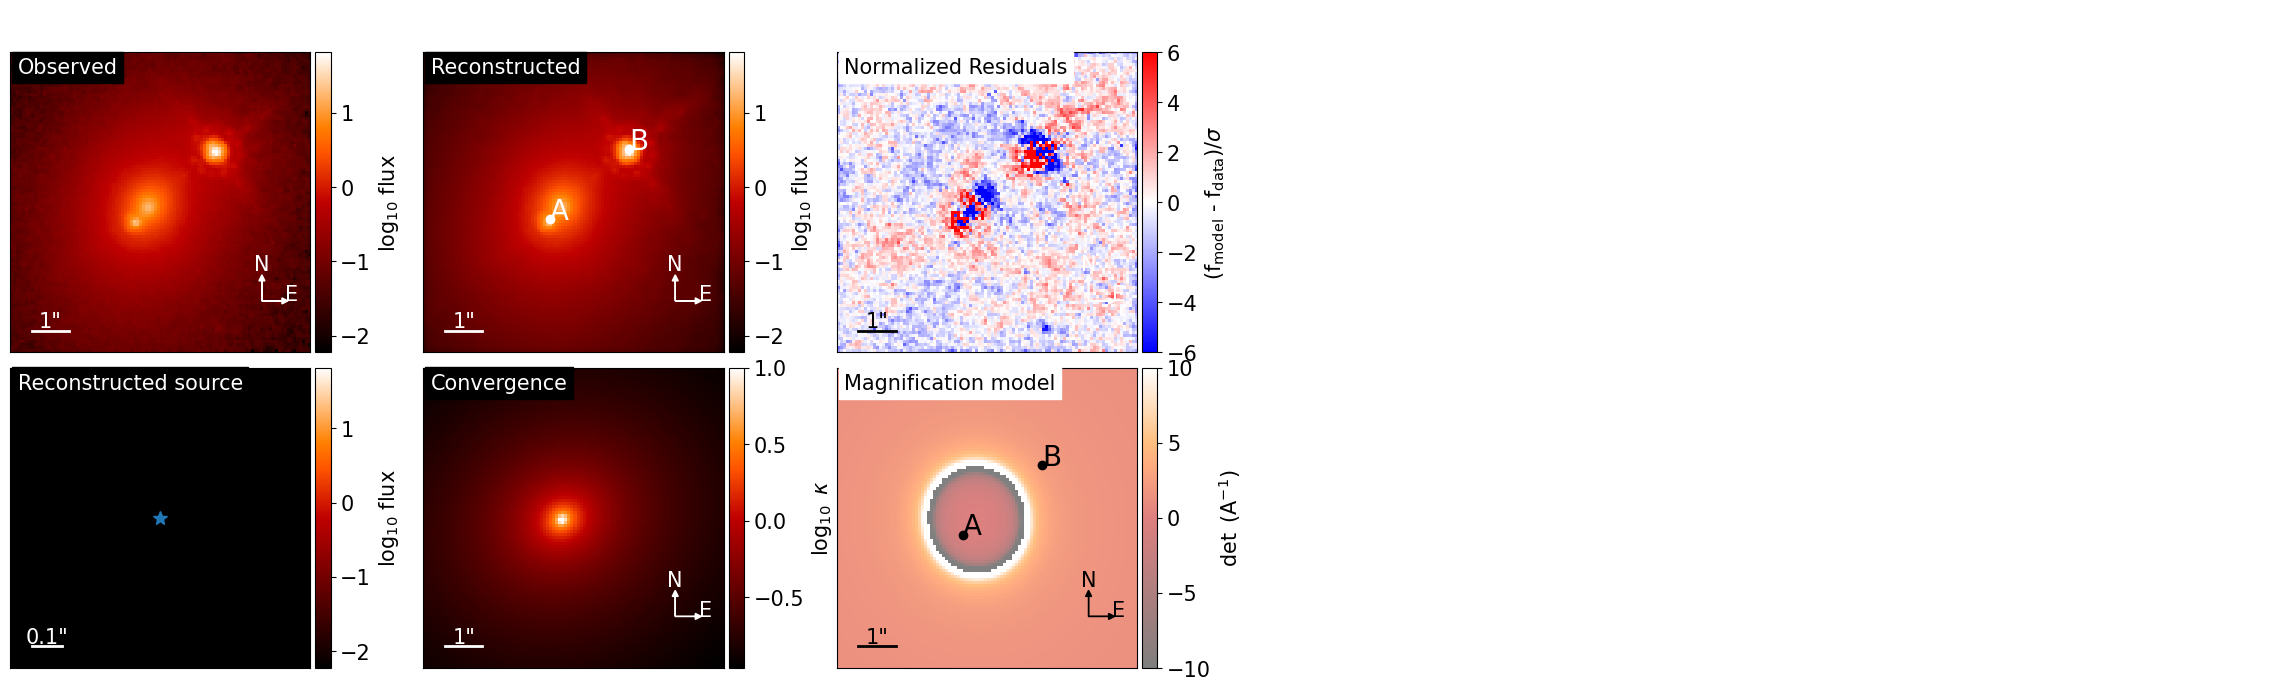

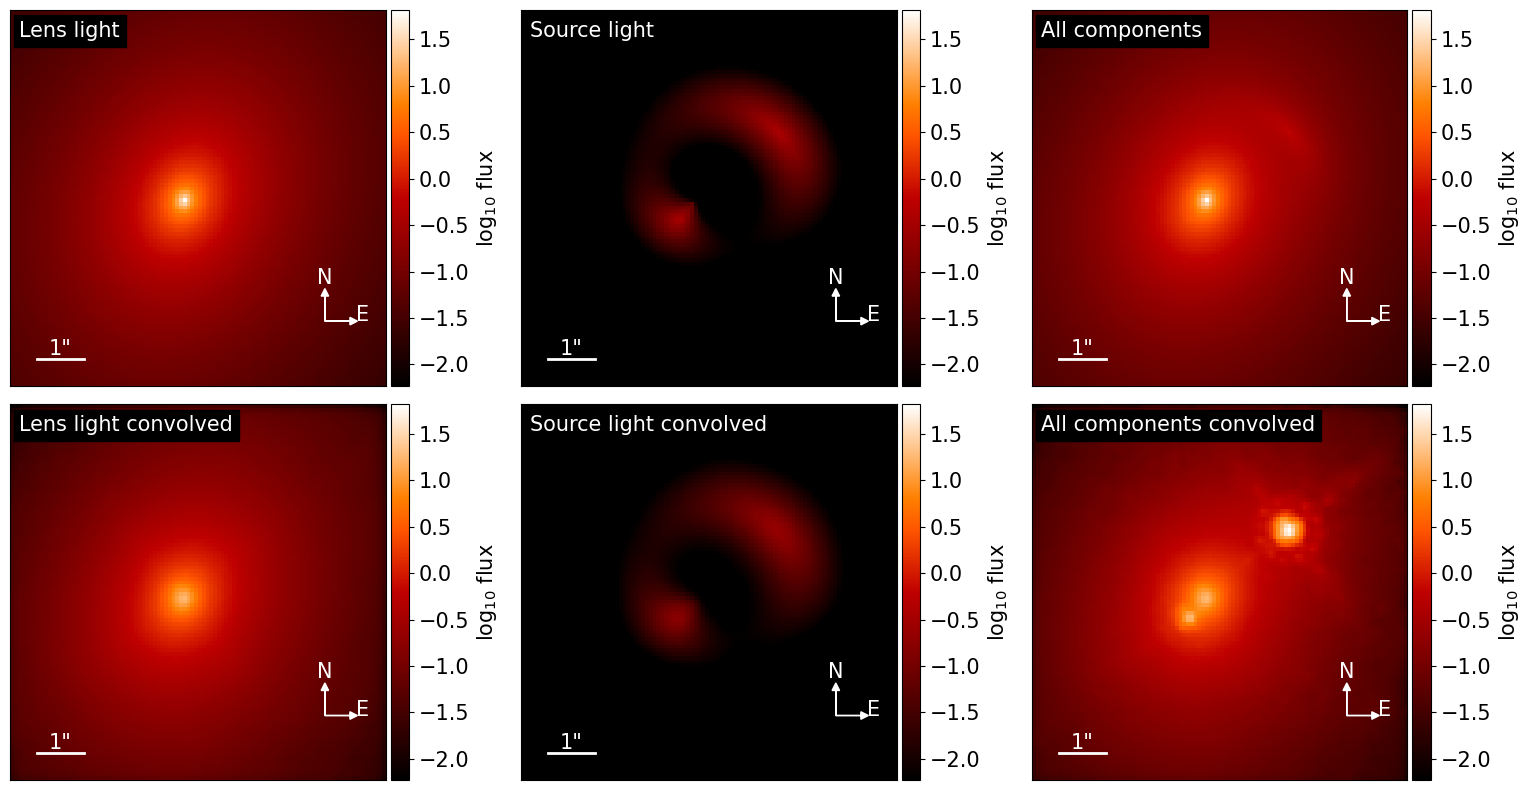

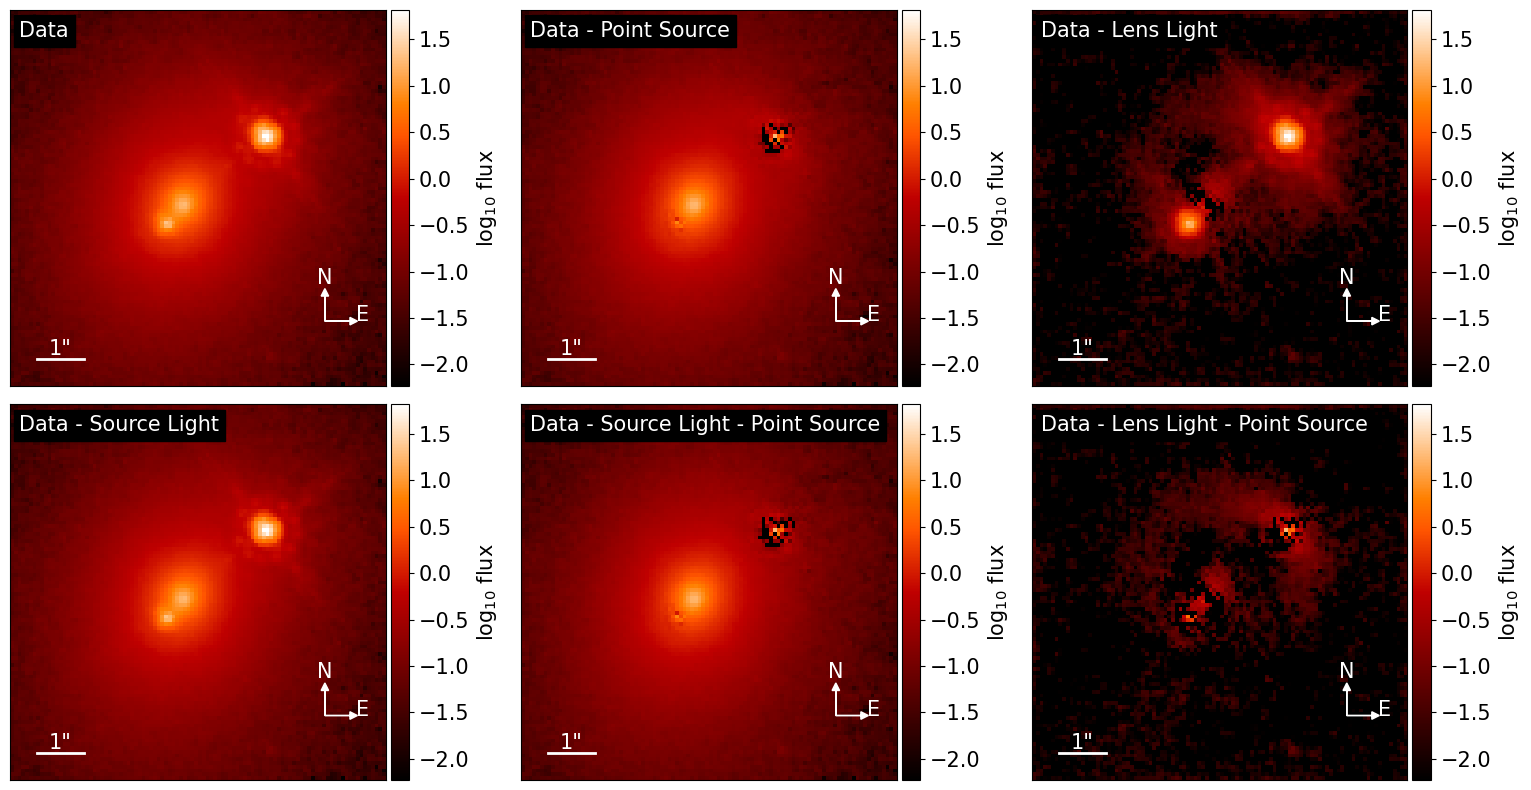

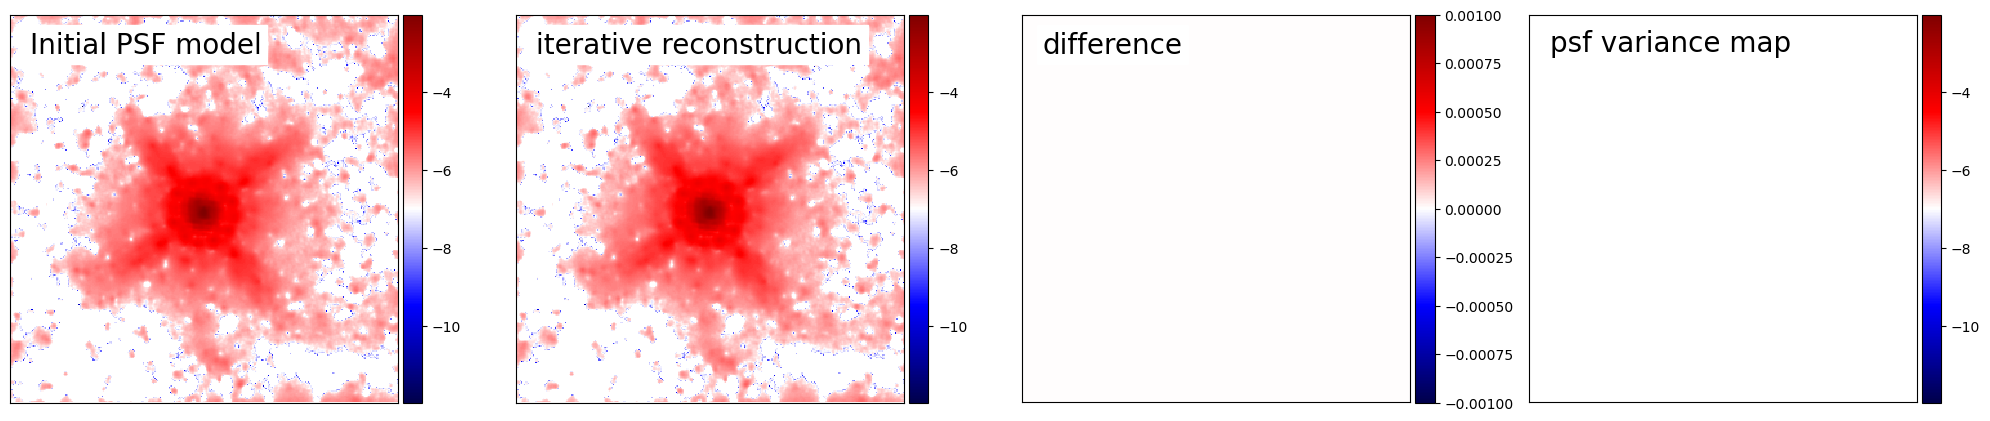

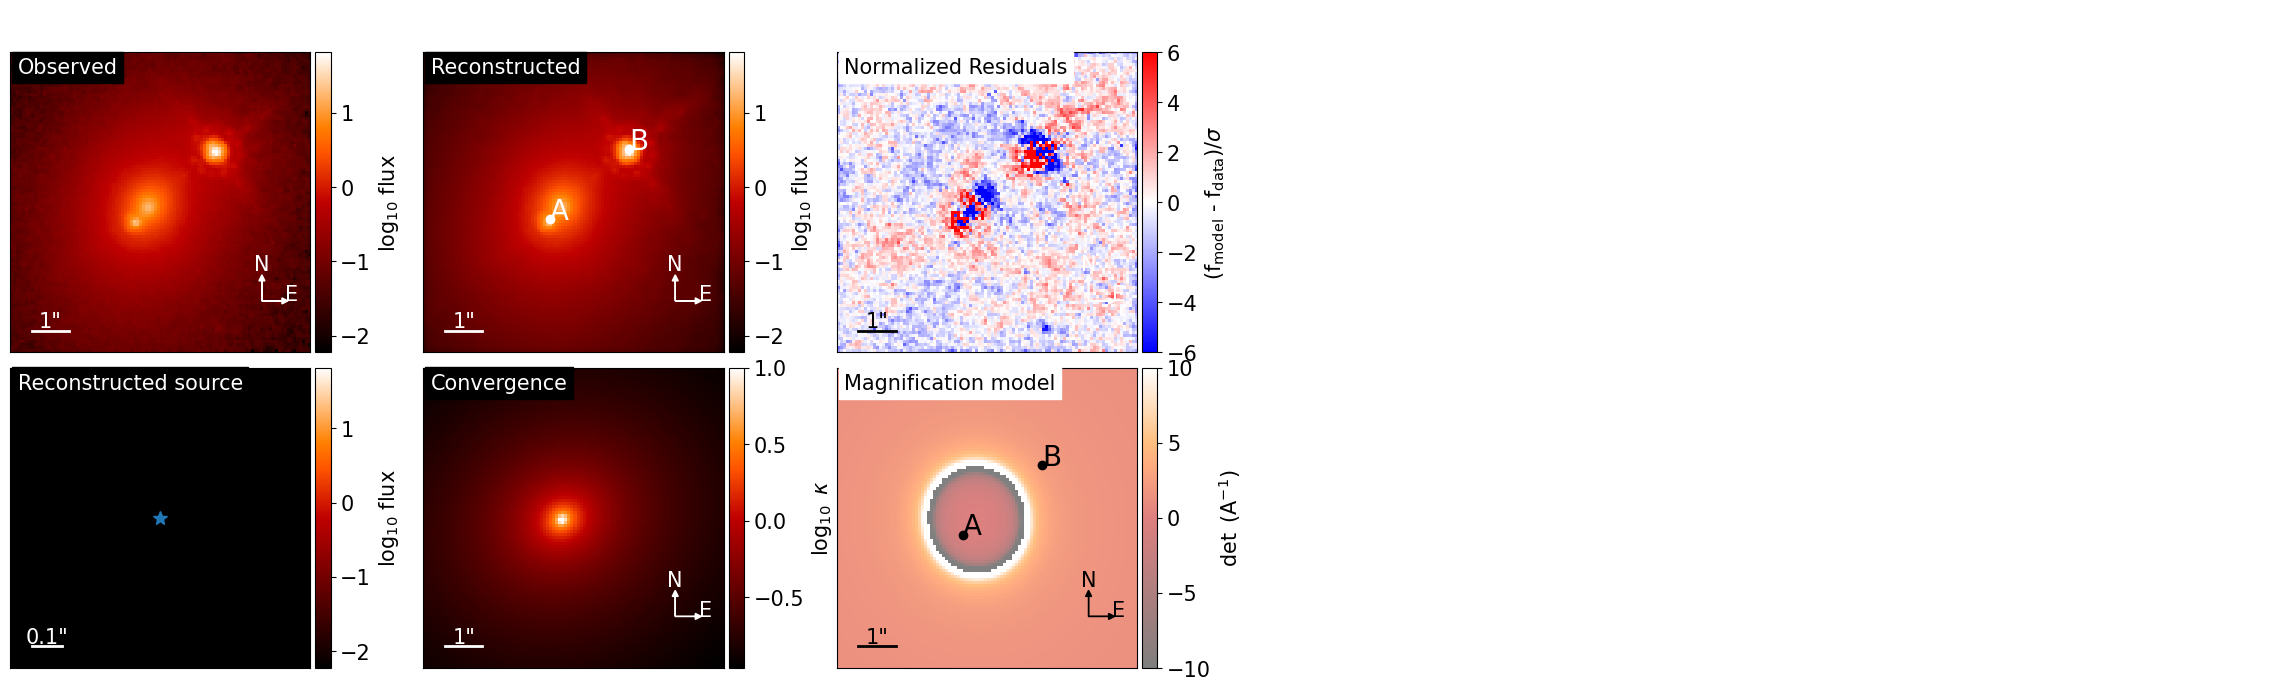

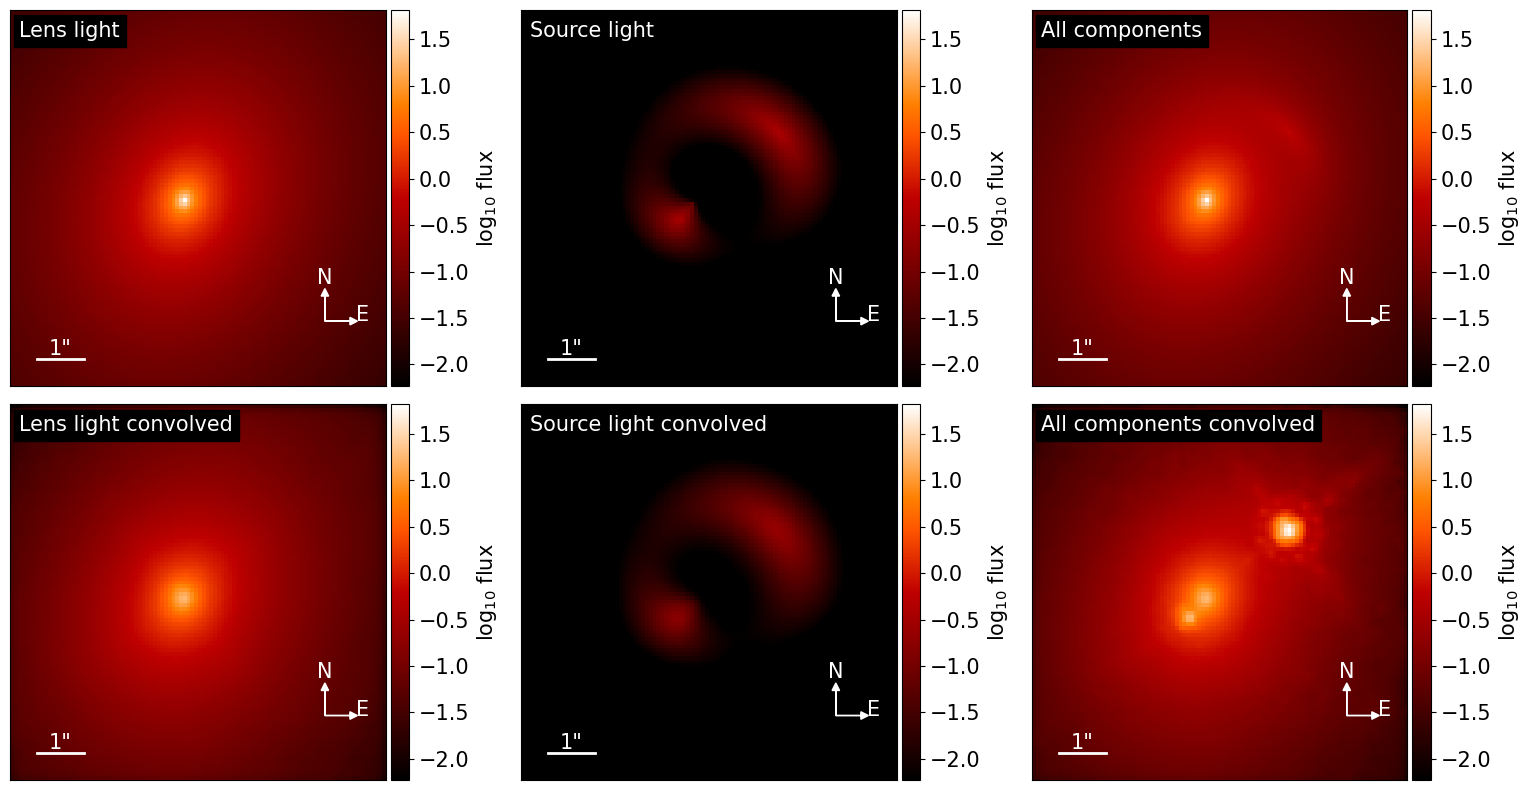

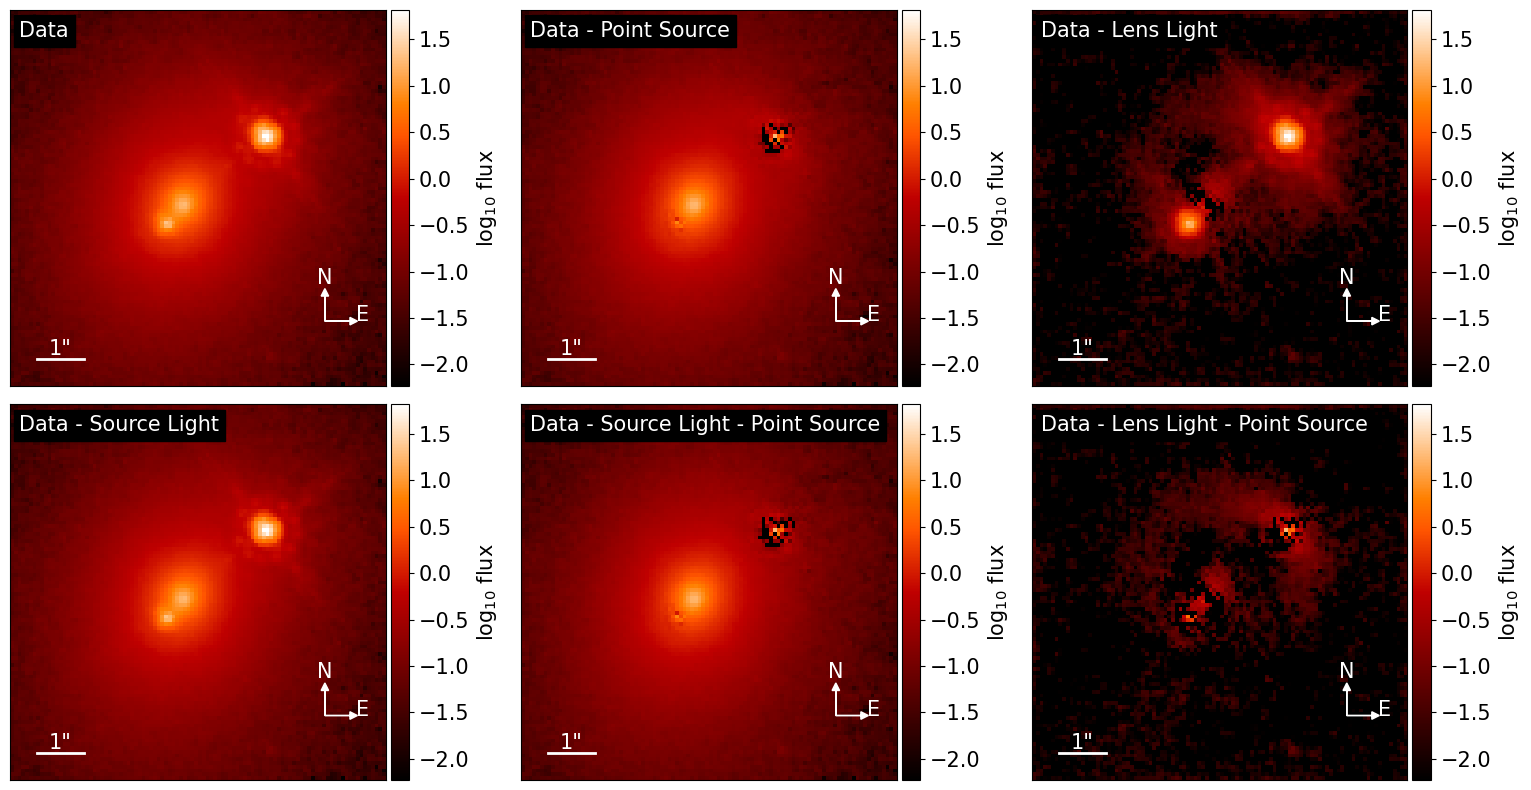

In [ ]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 50, 
                    'psf_iter_factor': 0.2,
                    'keep_psf_variance_map': True,
                    'compute_bands': [True, False, False]
                      }

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

from IPython.display import display

f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
display(f)

modelPlot = ModelPlot(new_multiband, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

f, axes = modelPlot.plot_main()
display(f)

f, axes = modelPlot.plot_separate()
display(f)

f, axes = modelPlot.plot_subtract_from_data_all()
display(f)

In [18]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 100, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [False, True, False]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, False]},  # now fit both bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO of both bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

Computing the Alignment fitting for band 1 ... ...


100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


Max iteration reached! Stopping.
Shifts found:  [0.22732479974919884, 0.12202251077266815, -0.001106390485733171]
263.8843011856079 time used for  Alignment fitting for band 1 ...
Align completed for band 1.
ra_shift: 0.22732479974919884,  dec_shift: 0.12202251077266815, phi_rot: -0.001106390485733171


  0%|          | 0/100 [04:04<?, ?it/s]


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1218: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


-9.23460334428893 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.234603344288928


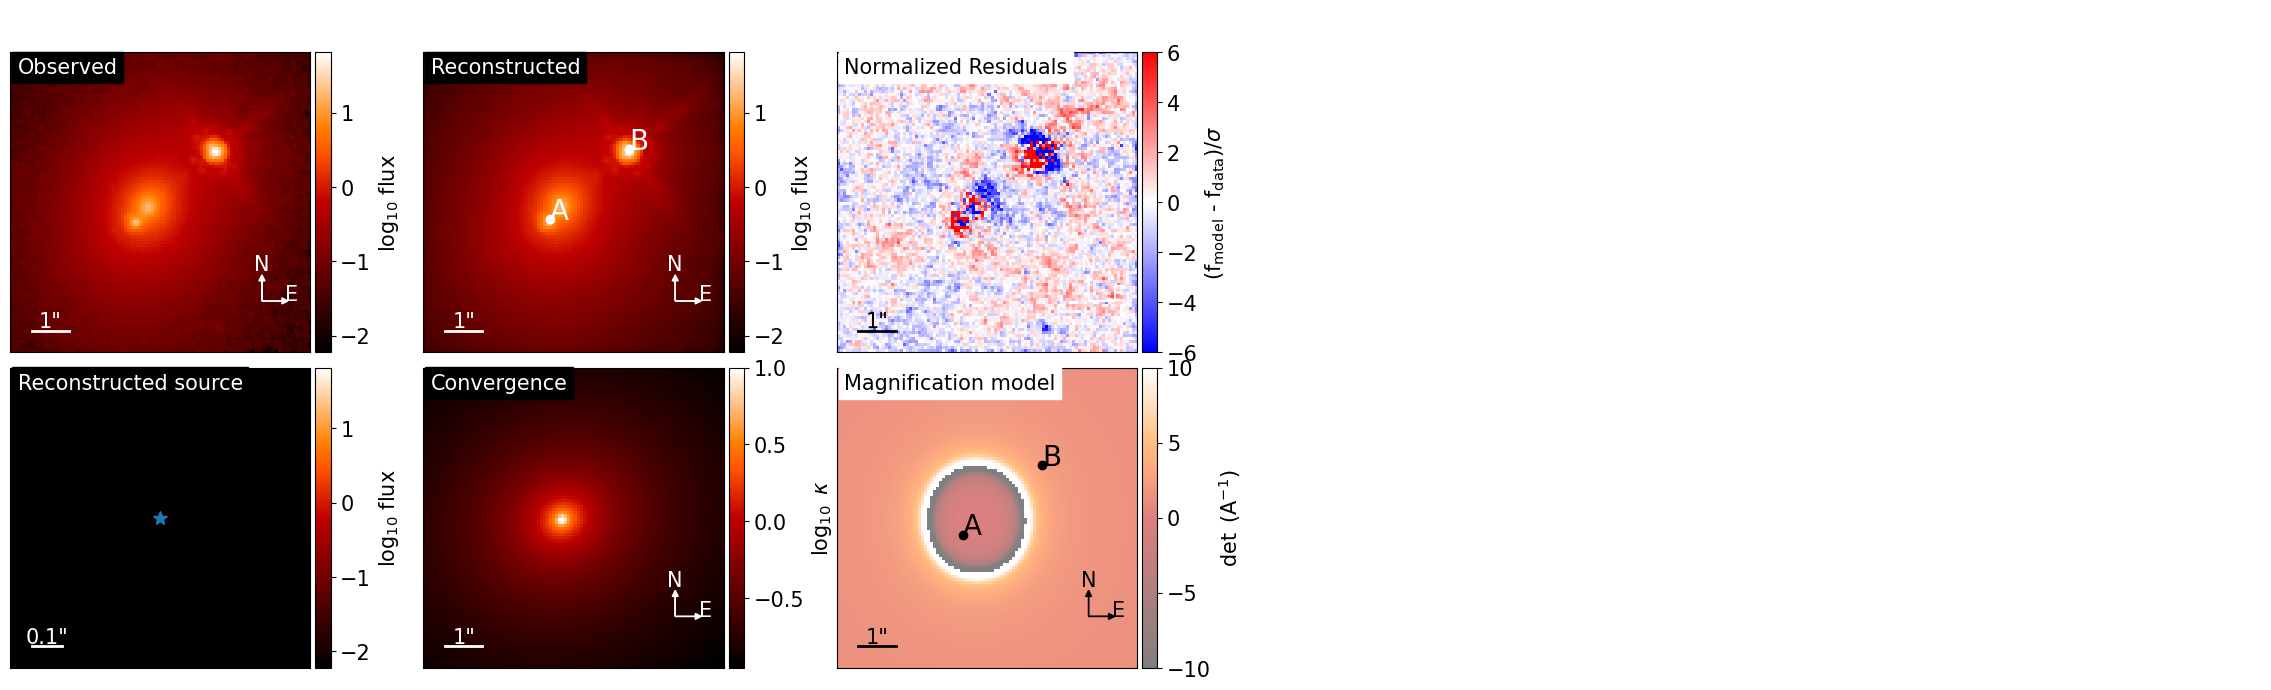

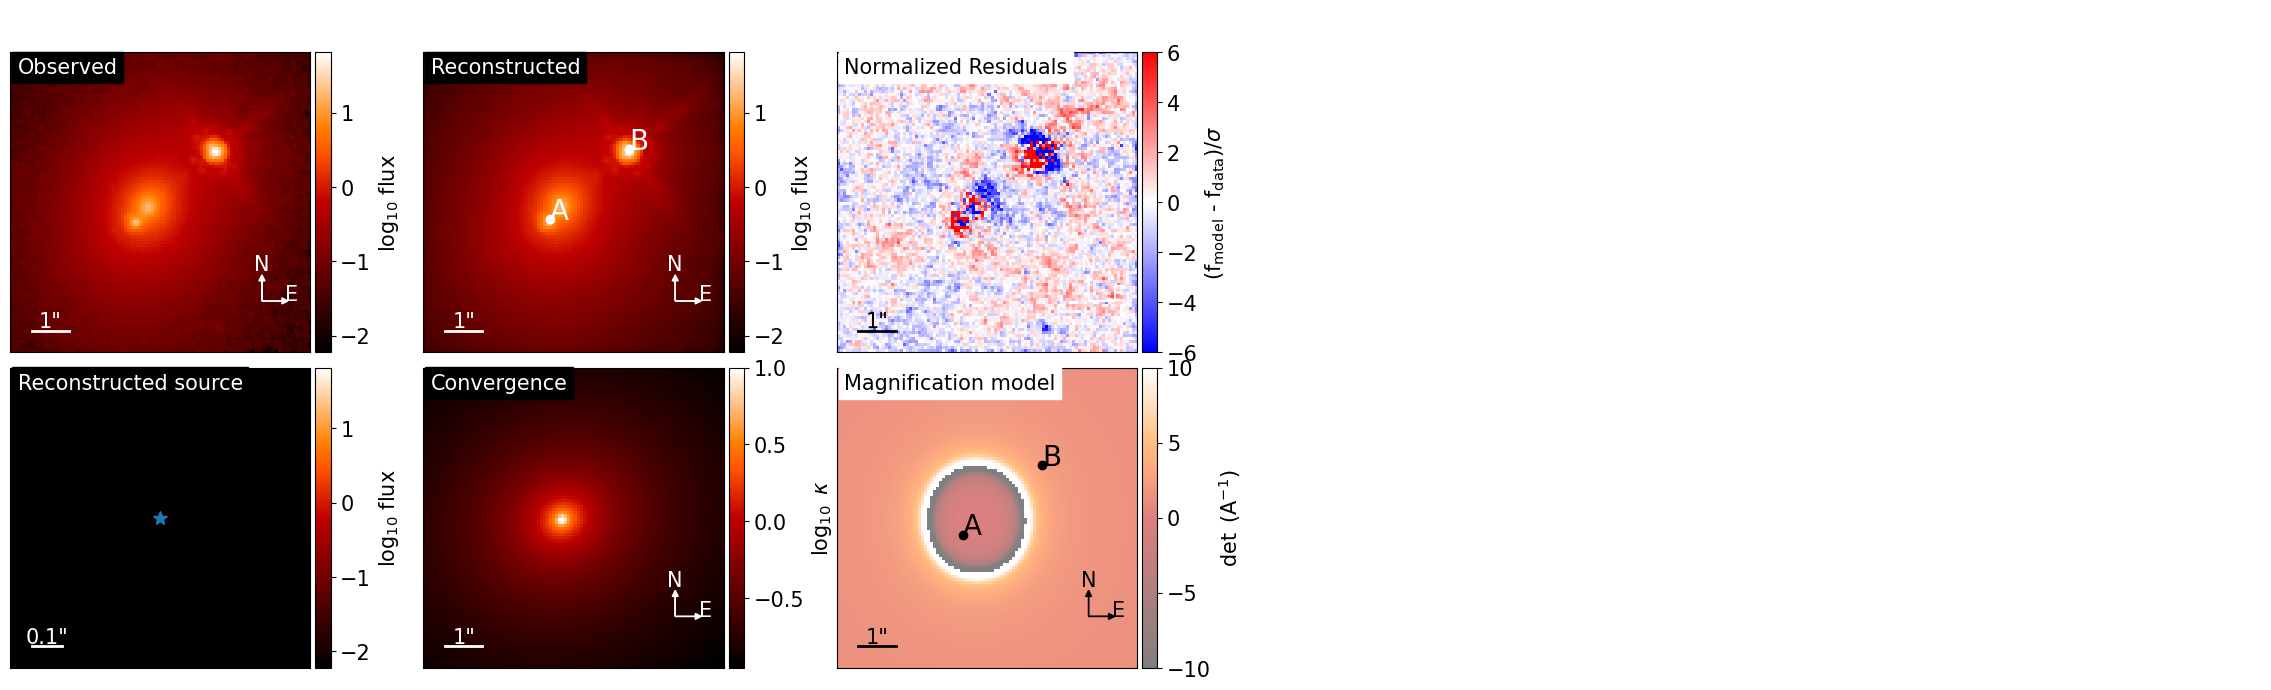

In [21]:
filter_index = 0
single_band = [new_multiband[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f

-1.0884695103836943 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  1.088469510383694


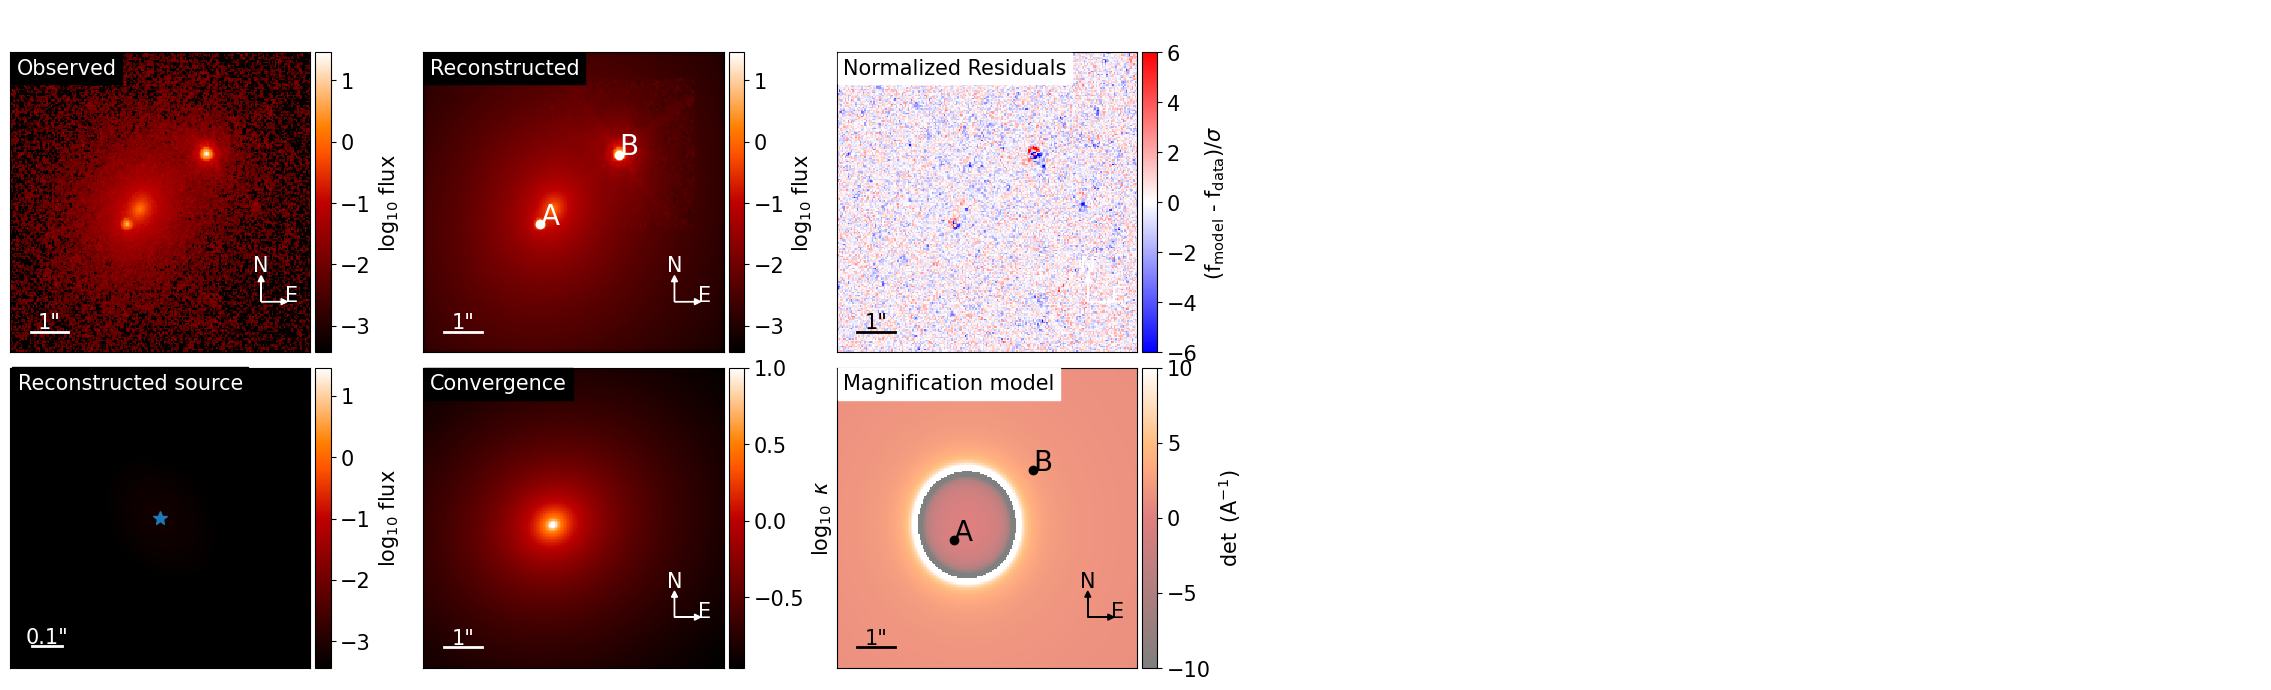

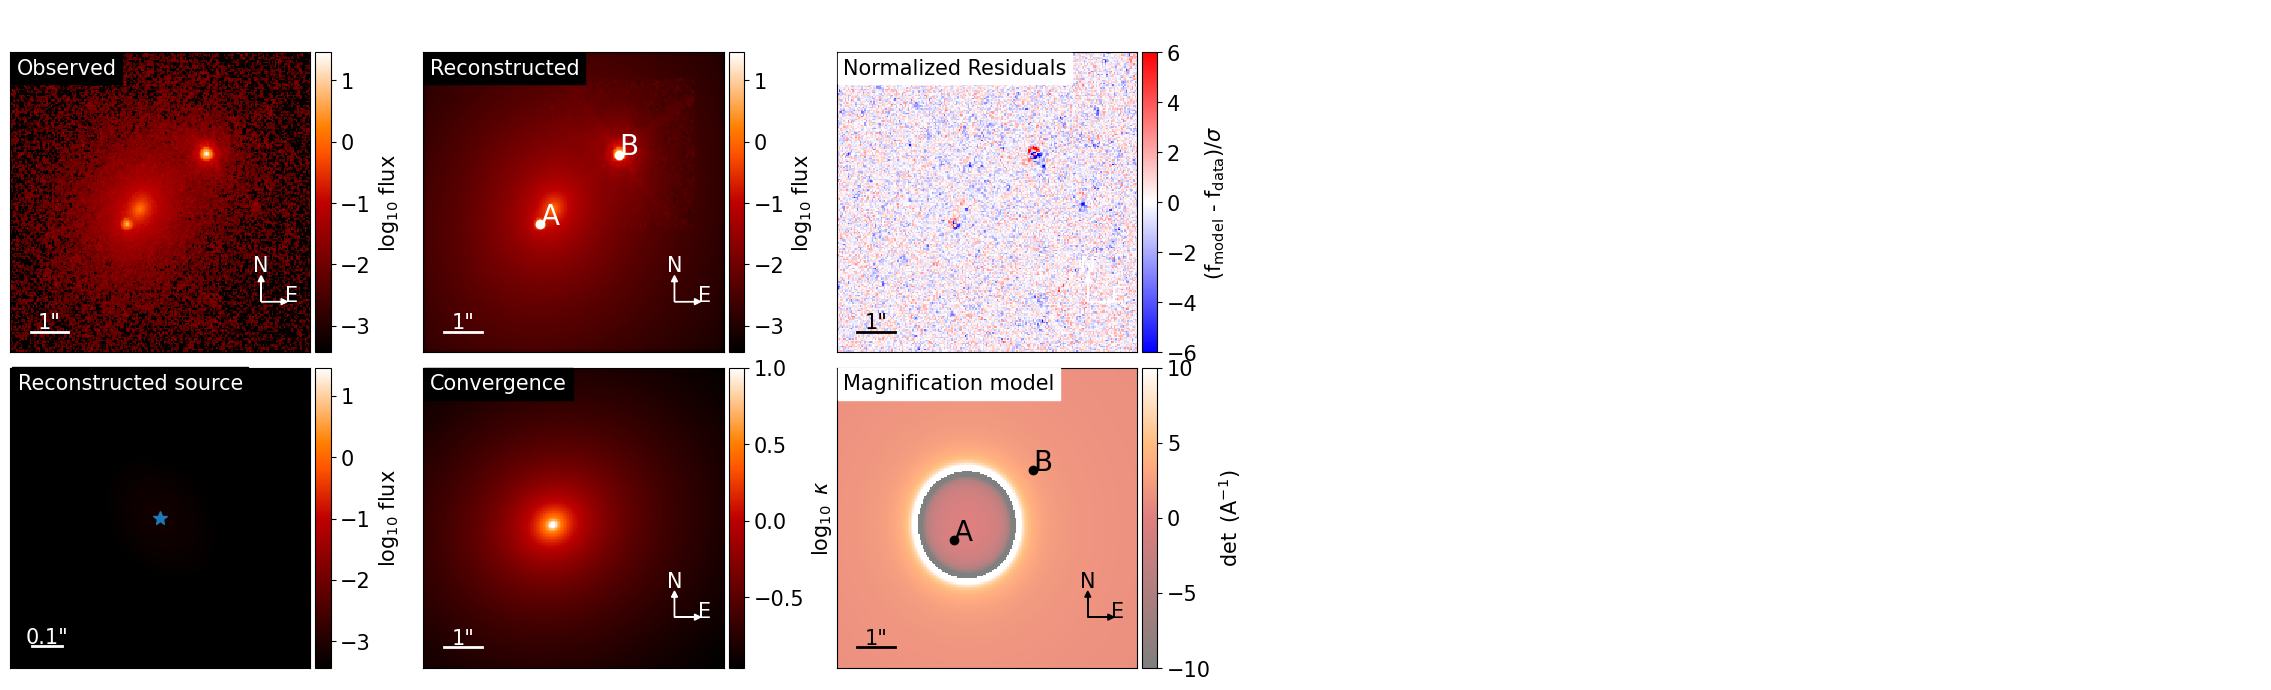

In [22]:
filter_index = 1
single_band = [new_multiband[filter_index]]

# Create ModelPlot with single-band list
modelPlot = ModelPlot(single_band, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

# Plot
f, axes = modelPlot.plot_main()
f

iteration of step 0 gave best reconstruction.
log likelihood before: -46173.01672144465 and log likelihood after: -46173.01672144465
iteration of step 1 gave best reconstruction.
log likelihood before: -21769.39020767389 and log likelihood after: -21184.398795554545


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:138: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_in), origin="lower", **kwargs)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:159: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(psf_out), origin="lower", **kwargs)
/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/chain_plot.py:200: RuntimeWarning: divide by zero encountered in log10
  np.log10(psf_variance_map * psf.kernel_point_source**2),


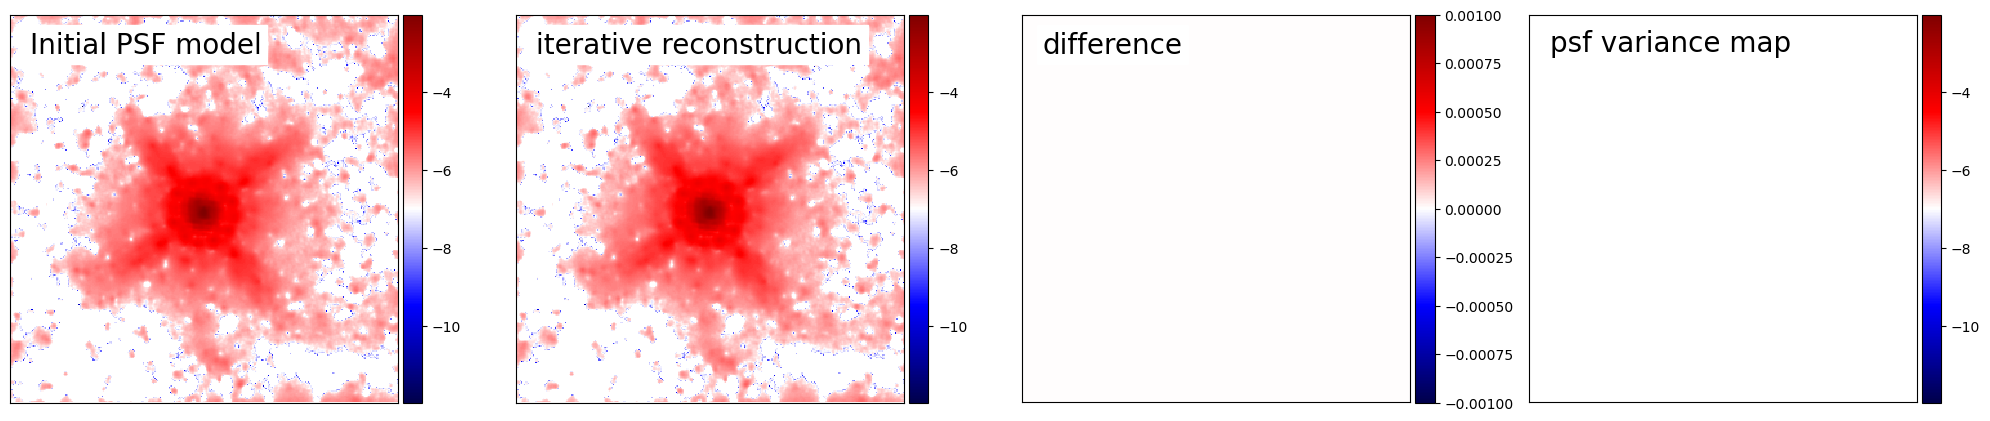

-378.6947995458942 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.234603344288928
reduced chi^2 of data  1 =  1.0592199397777273
reduced chi^2 of data  2 =  848.6954282024125


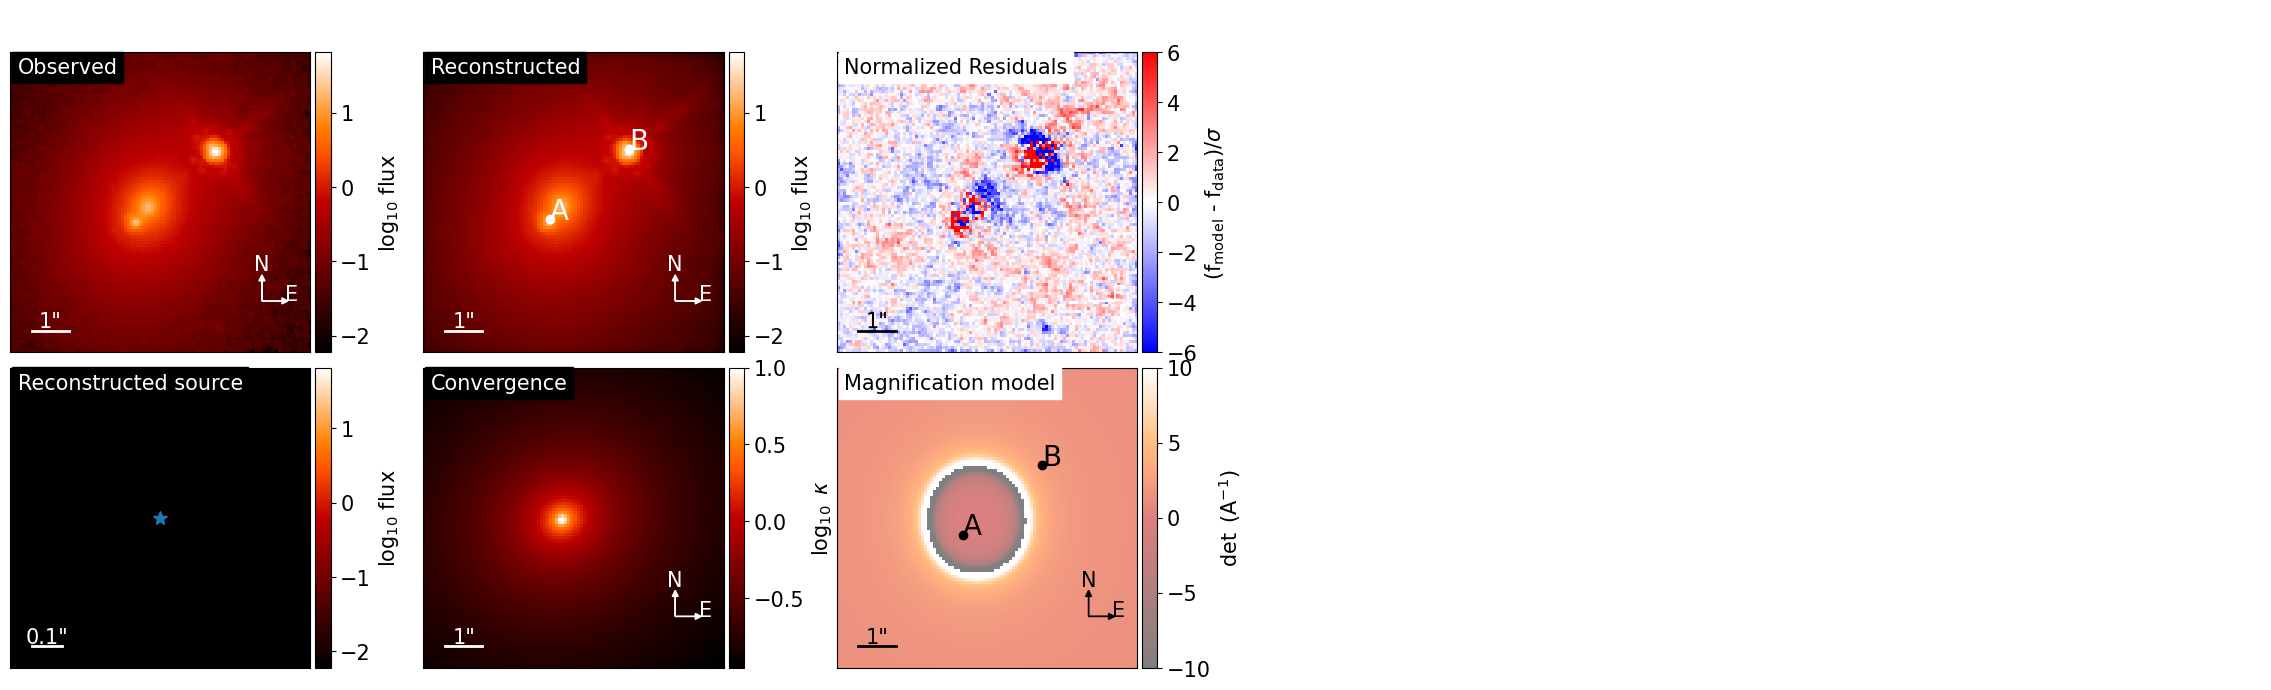

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


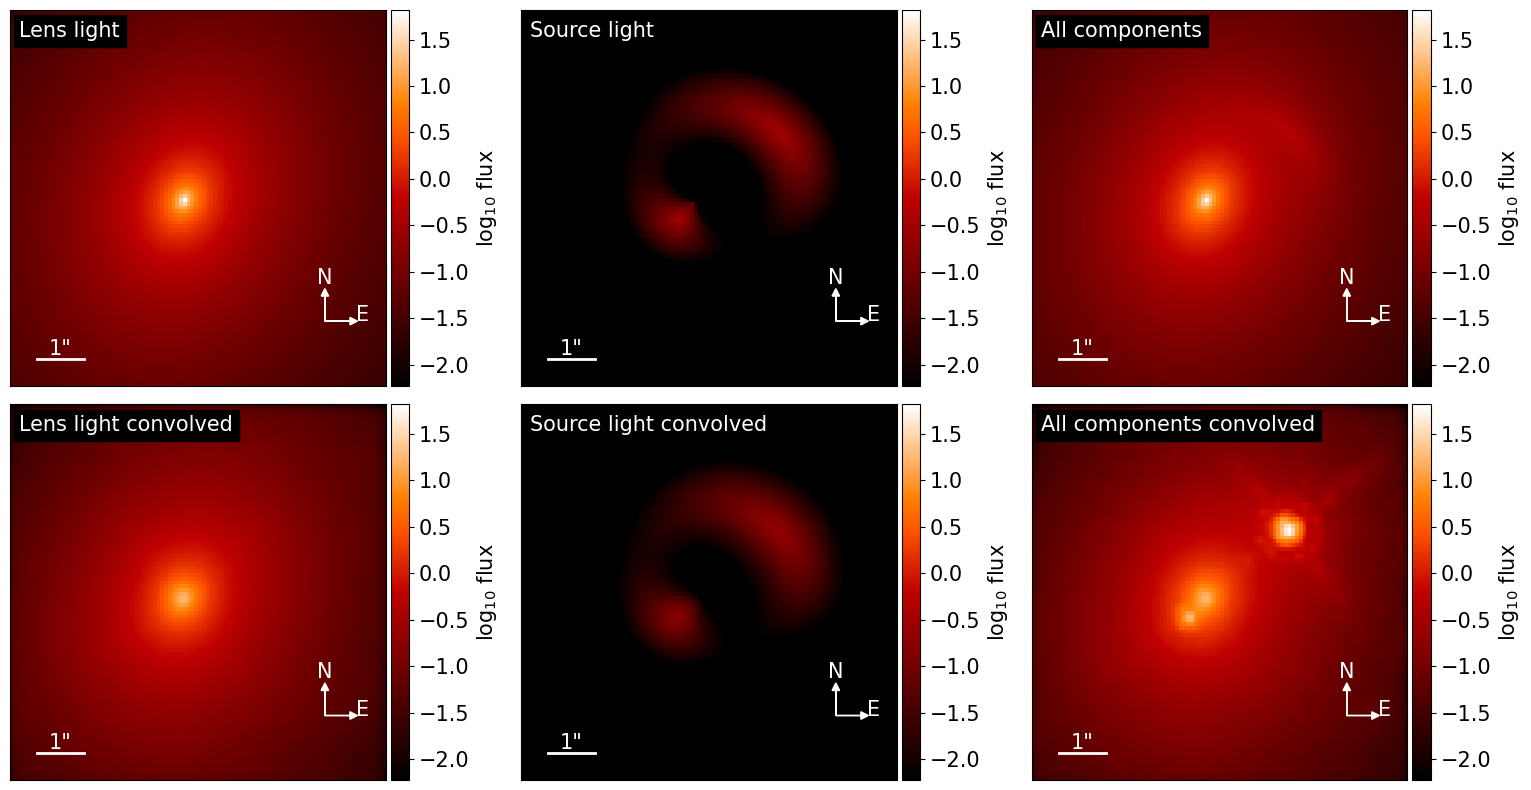

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1168: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data - model),


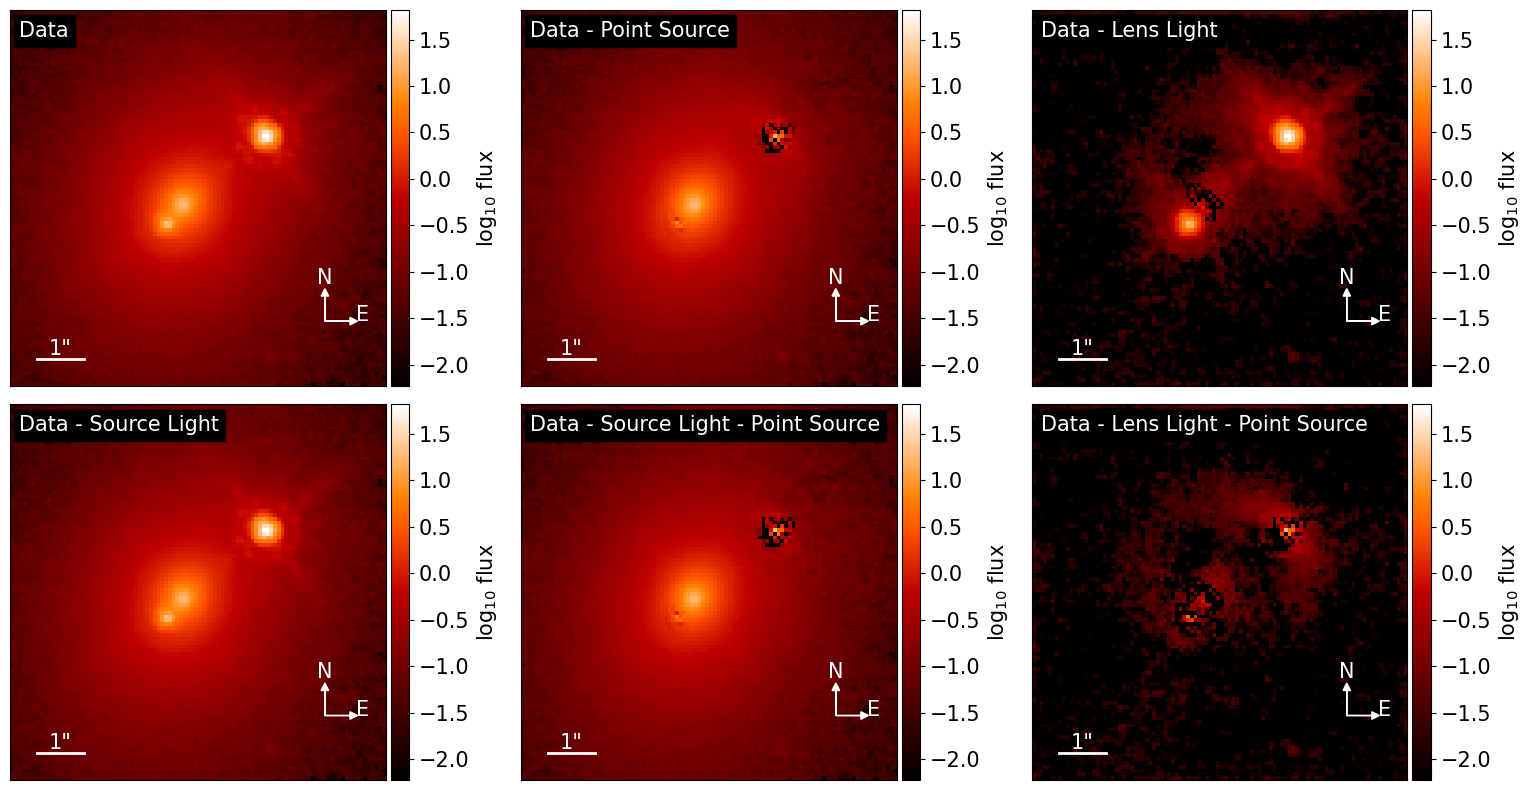

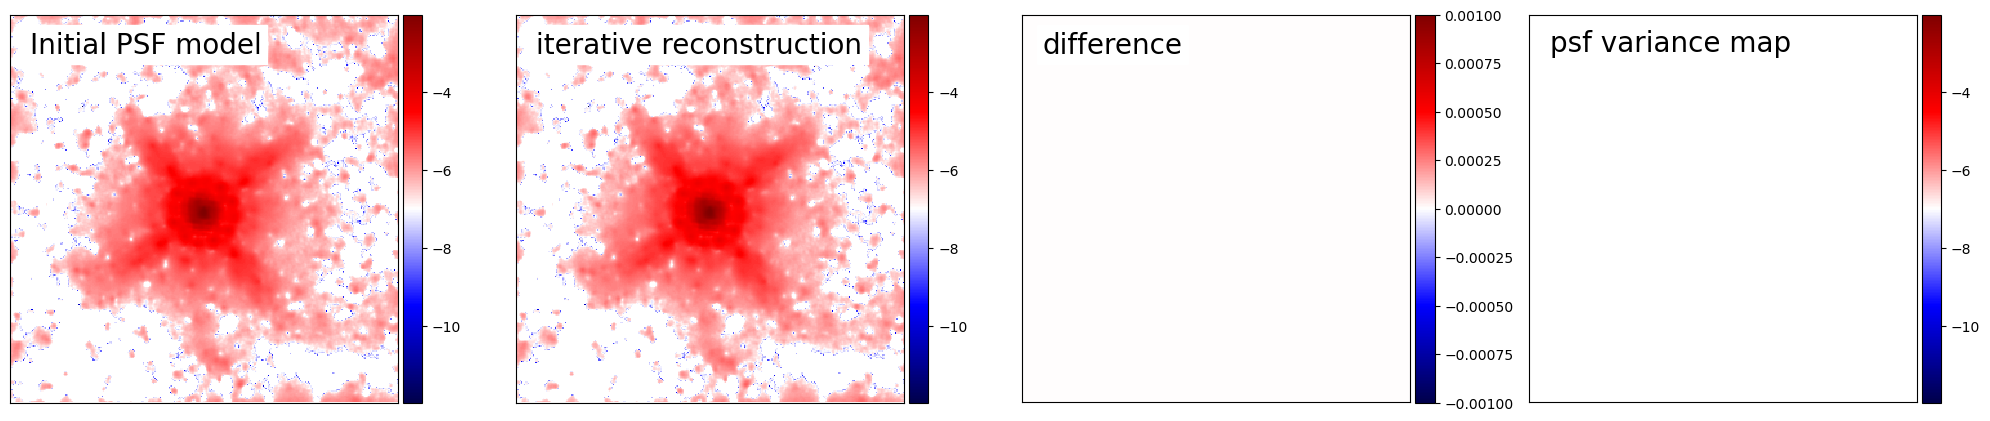

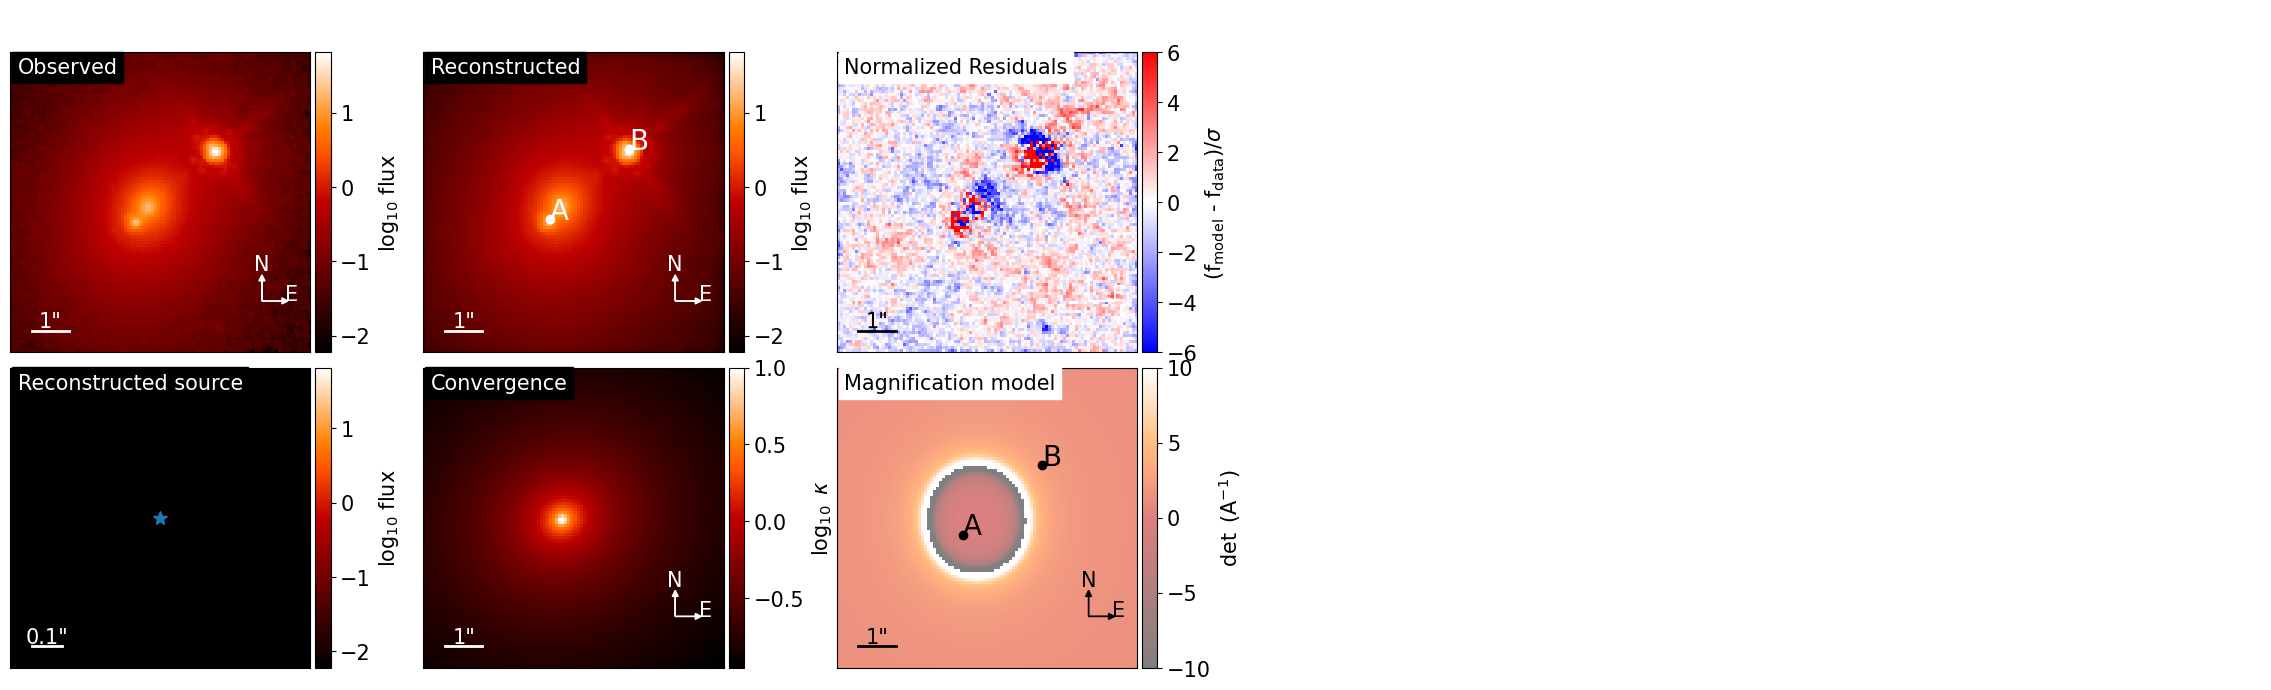

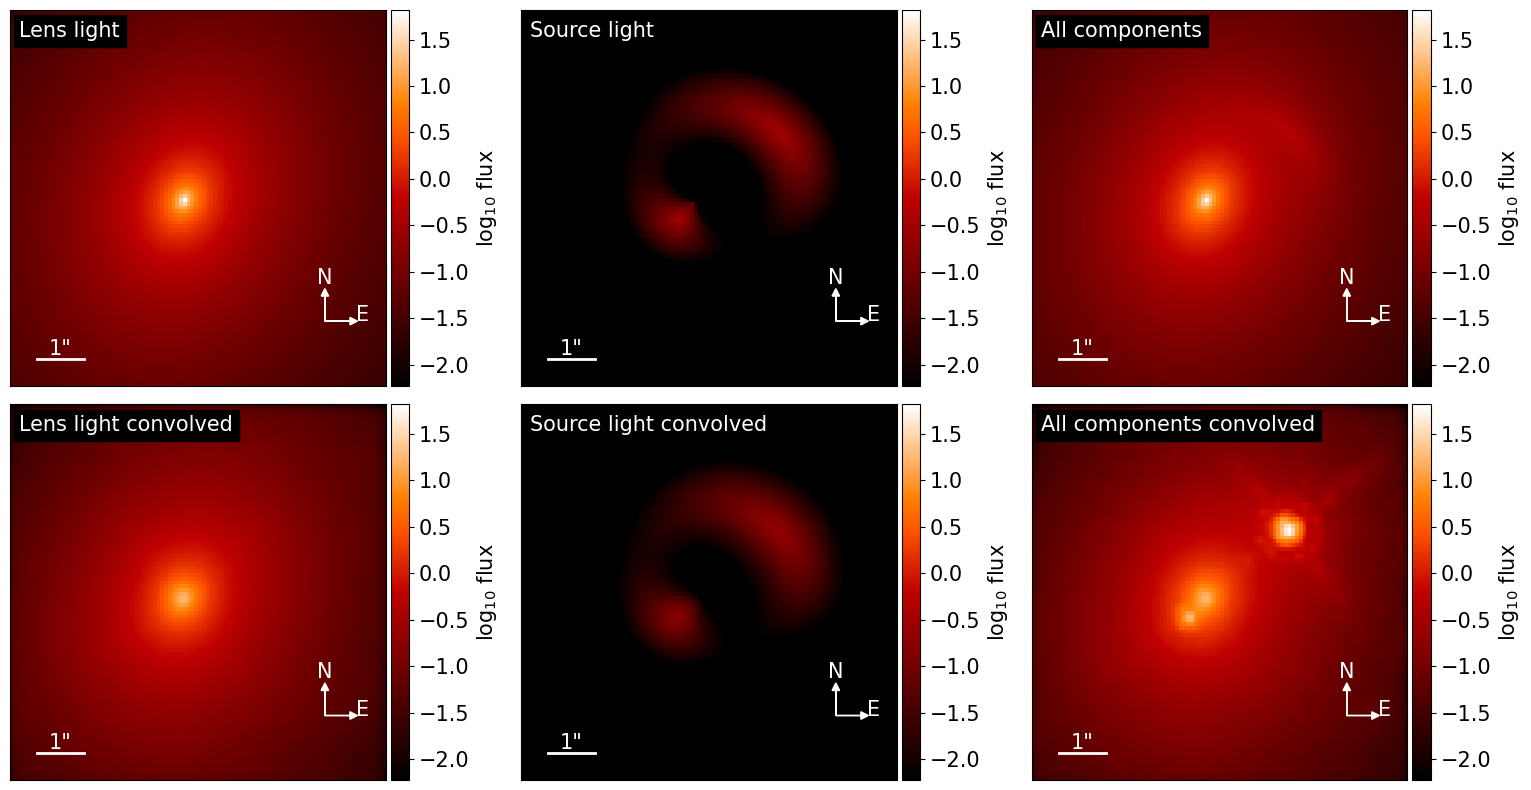

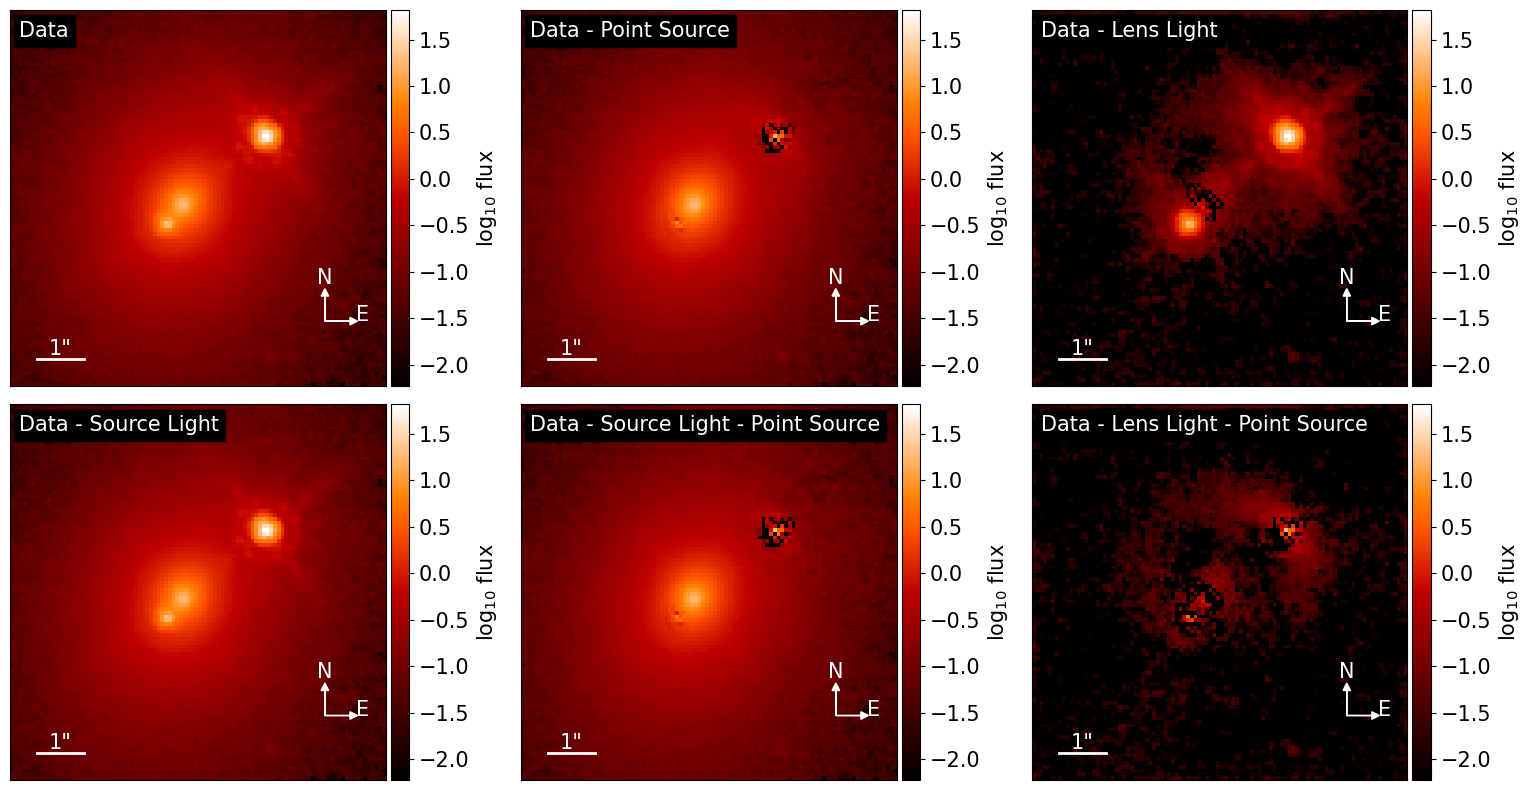

In [ ]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 50, 
                    'psf_iter_factor': 0.2,
                    'keep_psf_variance_map': True,
                    'compute_bands': [True, True, False]
                      }

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

from IPython.display import display

f, axes = chain_plot.psf_iteration_compare(kwargs_psf_updated)
display(f)

modelPlot = ModelPlot(new_multiband, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

f, axes = modelPlot.plot_main()
display(f)

f, axes = modelPlot.plot_separate()
display(f)

f, axes = modelPlot.plot_subtract_from_data_all()
display(f)

In [24]:
def align_images():
    
    fitting_kwargs_list = [
        ['align_images', {'n_particles': 100, 'n_iterations': 100, 
                      'align_offset': True, 'align_rotation': True, 
                      'delta_shift': .1, 'delta_rot': .1,
                      'compute_bands': [False, False, True]}],  # align second image
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True, True, True]},  # now fit both bands jointly
                        }], 
        ['PSO', {'sigma_scale': 1., 'n_particles': 100, 'n_iterations': 100}],  # run PSO of both bands
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    new_multiband = fitting_seq.multi_band_list

    return chain_list, kwargs_result, new_multiband

chain_list, kwargs_result, new_multiband = align_images()

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


Computing the Alignment fitting for band 2 ... ...


100%|██████████| 100/100 [04:22<00:00,  2.63s/it]


Max iteration reached! Stopping.
Shifts found:  [0.21124345146012422, 0.13151709337654405, -0.0010531278483774532]
262.89337277412415 time used for  Alignment fitting for band 2 ...
Align completed for band 2.
ra_shift: 0.21124345146012422,  dec_shift: 0.13151709337654405, phi_rot: -0.0010531278483774532


  0%|          | 0/100 [06:17<?, ?it/s]


In [25]:
#now we run an iterative PSF reconstruction with the best fit model of the previous run
method_PSF_iteration = 'stack' #use 'STARRED' to use the STARRED method for PSF reconstruction or 'stack' to use the standard lenstronomy stacking method

kwargs_lbfgs = {'maxiter':1000}

kwargs_optax1 = {'max_iterations': 500, 'min_iterations': None,
                'init_learning_rate': 1e-2, 'schedule_learning_rate': True,
                'progress_bar': True} 

if method_PSF_iteration == 'STARRED':
    kwargs_psf_iter = { 
                    'keep_psf_error_map': True, 
                    'psf_symmetry': 1, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 3, #we run STARRED more than once, to see if the chi2 keeps improving after redoing the linear inversion with the new PSF. 
                    'psf_iter_factor': 1, #We fully update the PSF at each iteration, if the fit improves
                    'kwargs_starred': {'verbose':True, 'lambda_scales':3, 'lambda_hf':3, #Choose regularisation parameters, lambda_scales and lambda_hf should be 2 or 3 if the noise is correctly scaled 
                                       'optim_list':['adabelief', 'adabelief'], 'kwargs_optim_list':[kwargs_optax1, kwargs_optax1],#Choose the optimisers to use, and pass the kwargs accordingly. One for the Moffat fit, one for the full PSF fit. 
                                       }, 
                    'use_starred': True, 
                    } 

else: 
    kwargs_psf_iter = {'stacking_method': 'median', 
                    'psf_symmetry': 4, 
                    'block_center_neighbour': 0.05,
                    'num_iter': 50, 
                    'psf_iter_factor': 0.2,
                    #'keep_psf_variance_map': True,
                    'compute_bands': [True, True, True]
                      }

fitting_kwargs_list = [['psf_iteration', kwargs_psf_iter]]
chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)

new_multiband = fitting_seq.multi_band_list
kwargs_psf_updated = multi_band_list[0][1]

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Data/psf.py:95: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


iteration of step 0 gave best reconstruction.
log likelihood before: -45761.61212078883 and log likelihood after: -45761.61212078883
iteration of step 0 gave best reconstruction.
log likelihood before: -21123.943501732414 and log likelihood after: -21123.943501732414
iteration of step 1 gave best reconstruction.
log likelihood before: -23696.17596612498 and log likelihood after: -22468.1446718082


-1.9856377843184319 reduced X^2 of all evaluated imaging data combined (without degrees of freedom subtracted).
reduced chi^2 of data  0 =  9.152322424157752
reduced chi^2 of data  1 =  1.0561971750866208
reduced chi^2 of data  2 =  1.12340723359041


/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:160: RuntimeWarning: invalid value encountered in log10
  np.log10(self._data),
/var/folders/74/9yc0dt9d53z15d2qpmgpxv4h0000gn/T/ipykernel_69521/2454496176.py:19: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


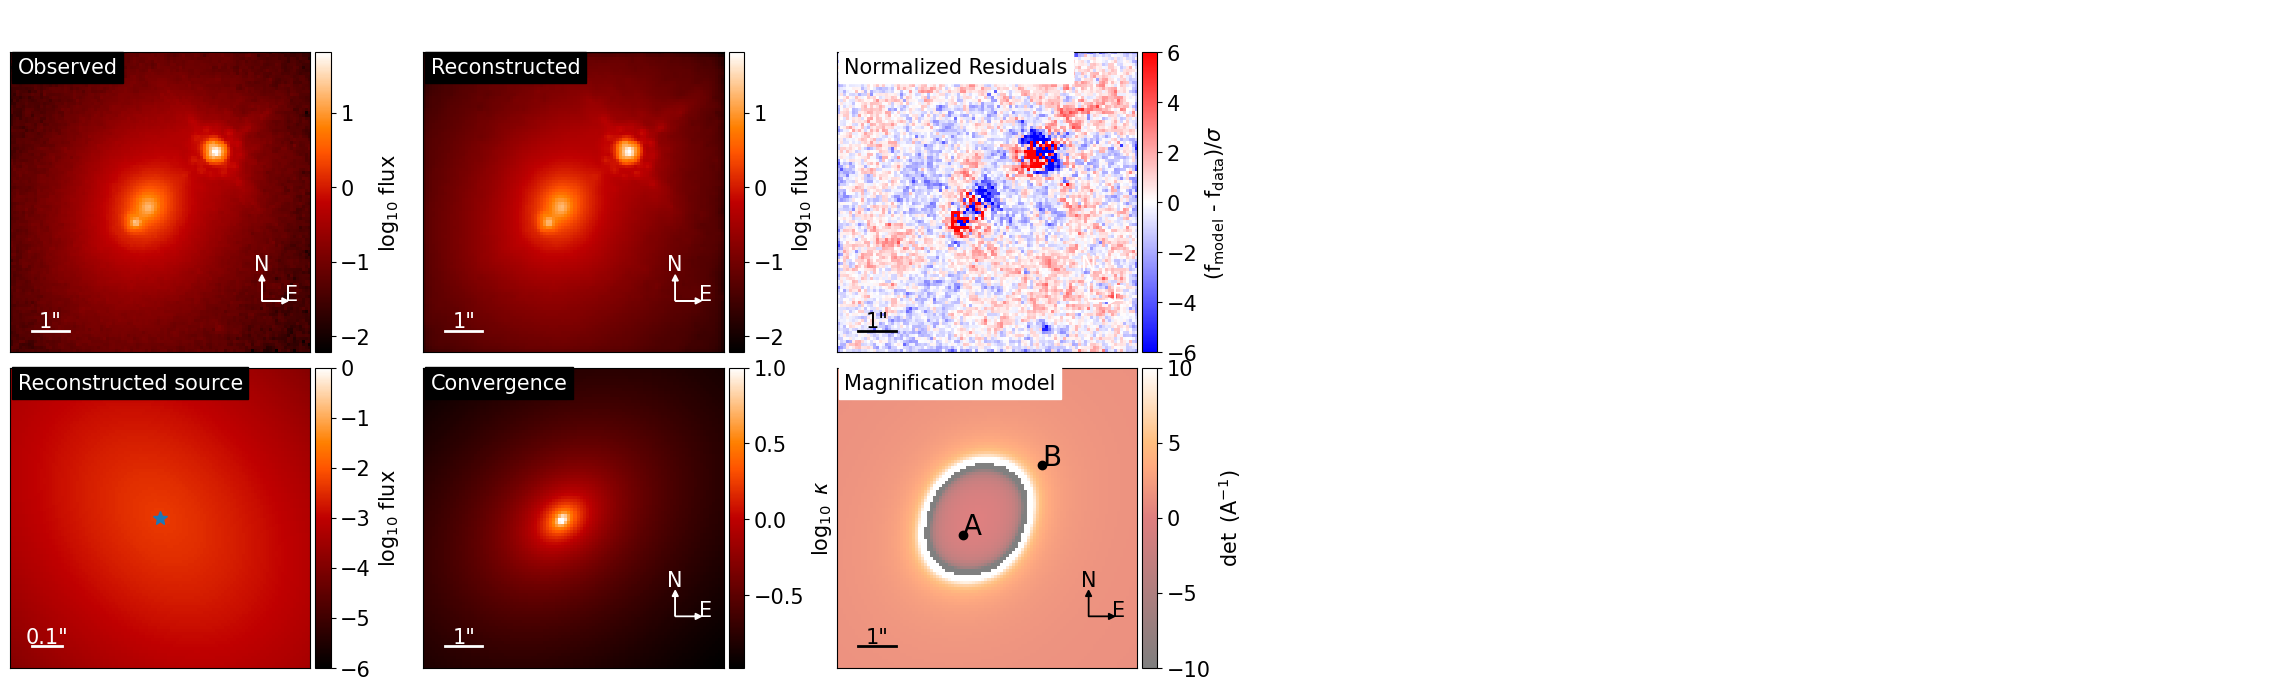

/Users/rbrady0110/micromamba/envs/doubles/lib/python3.13/site-packages/lenstronomy/Plots/model_band_plot.py:1111: RuntimeWarning: invalid value encountered in log10
  np.log10(model),


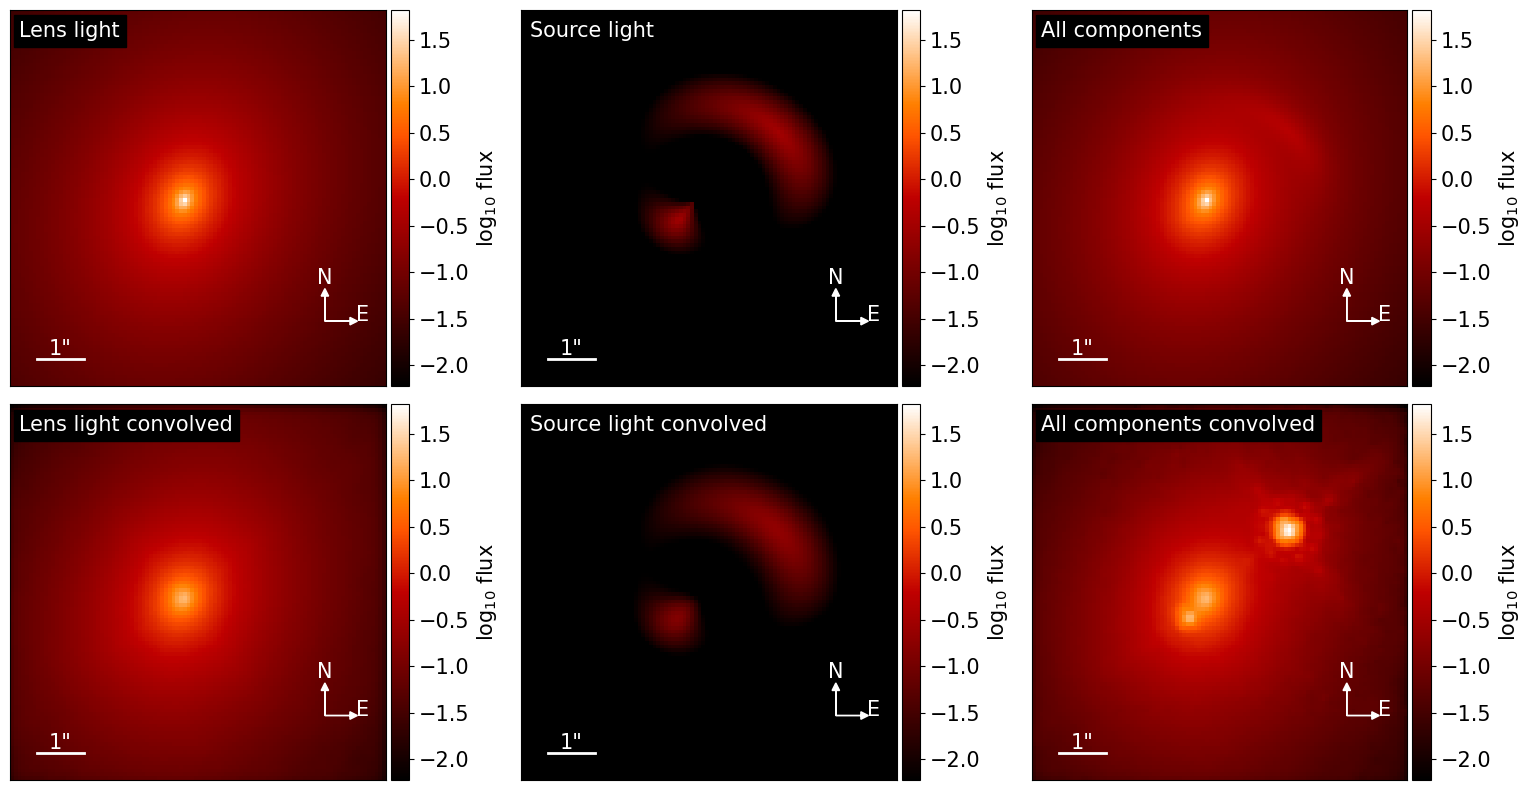

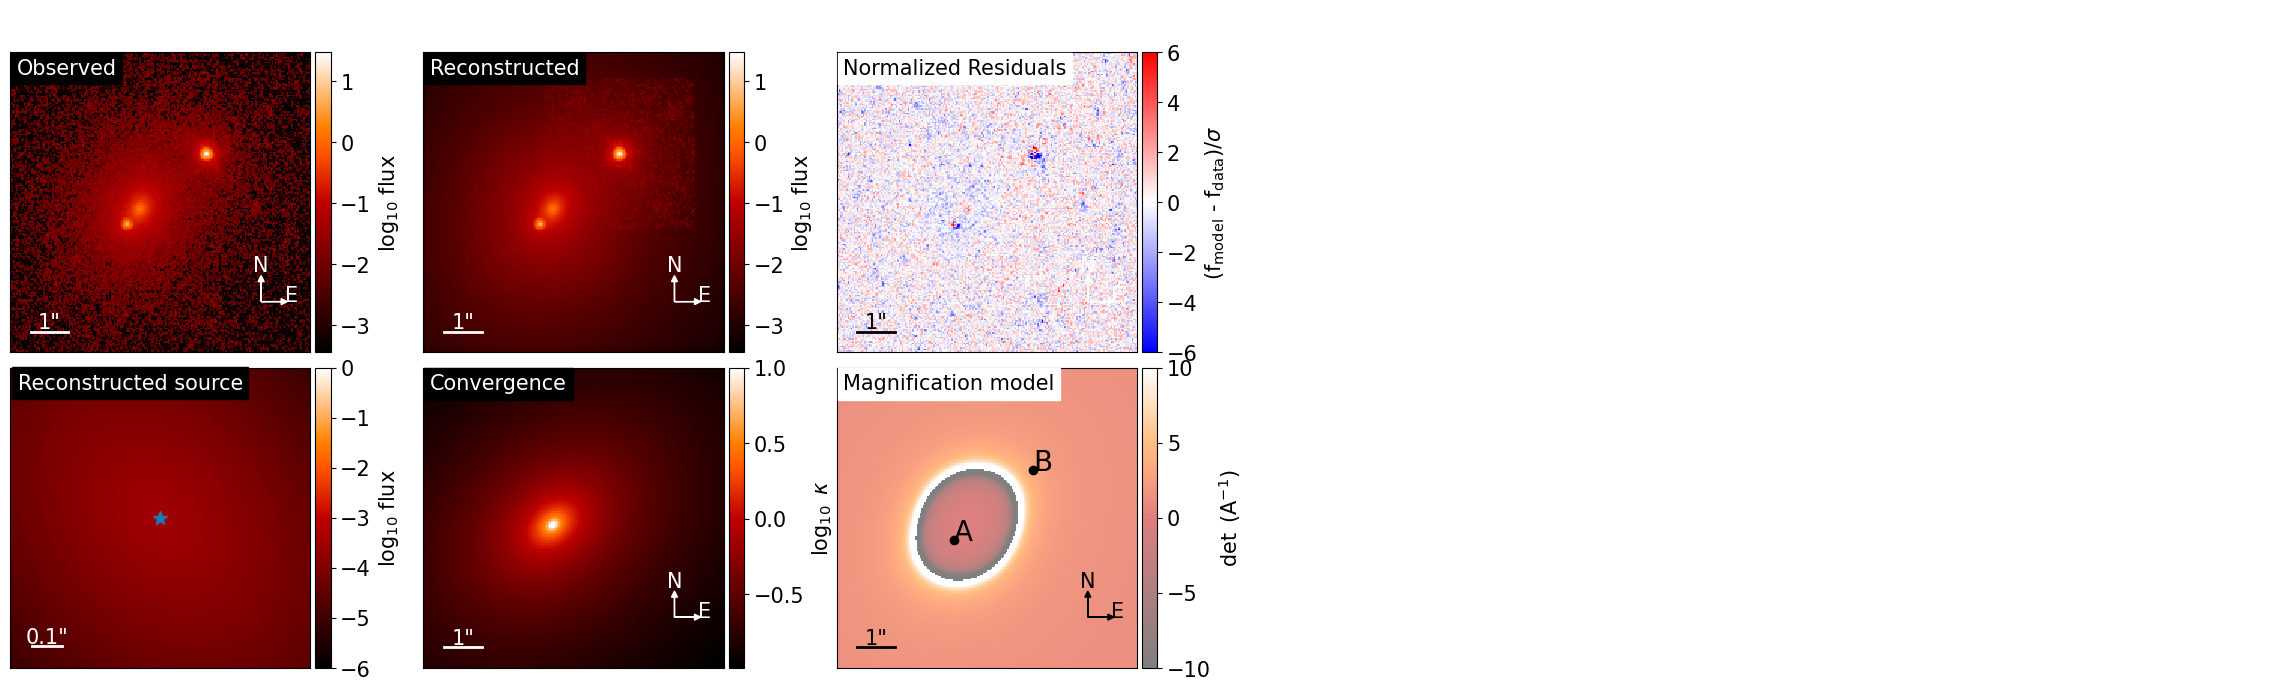

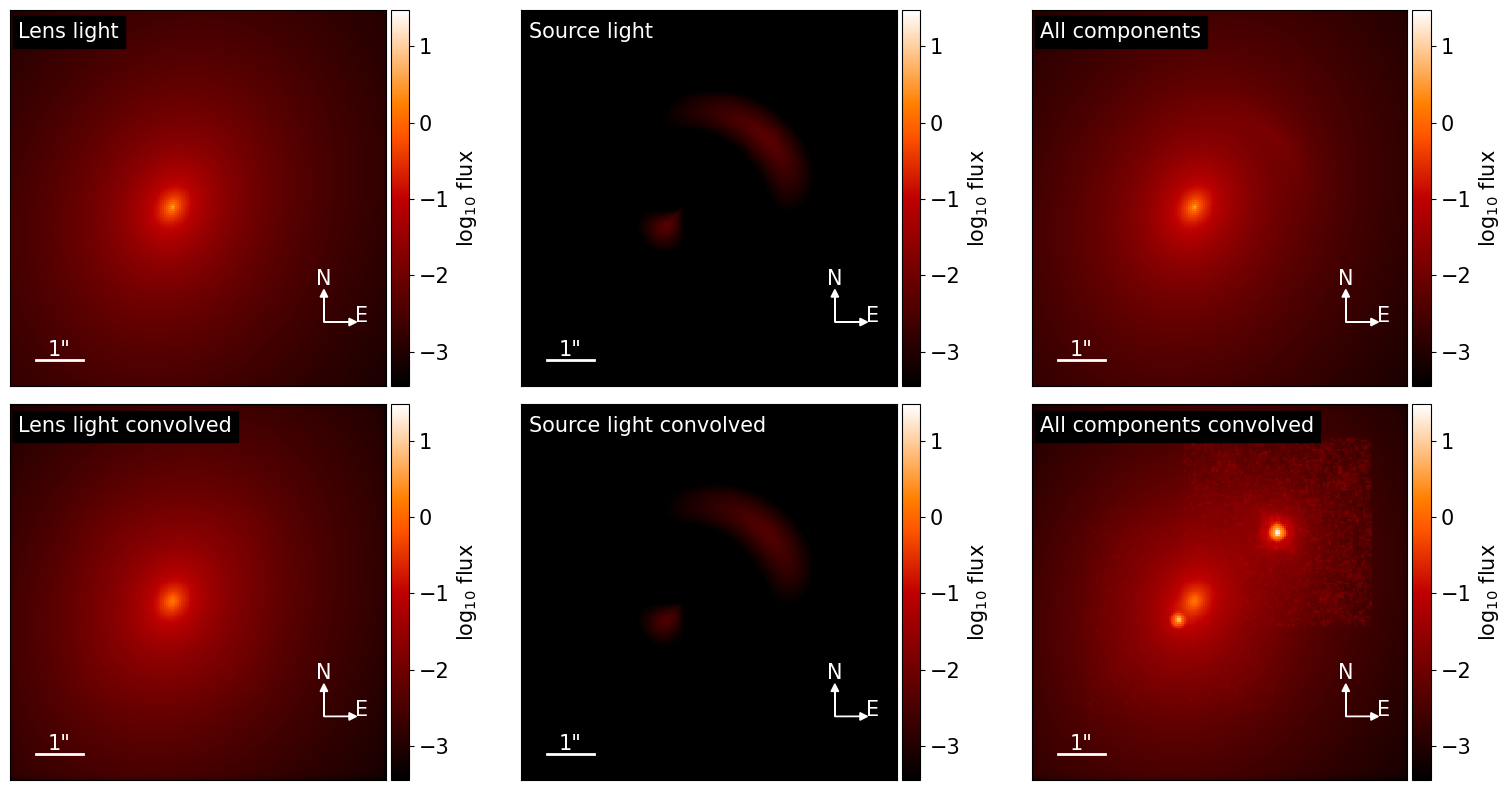

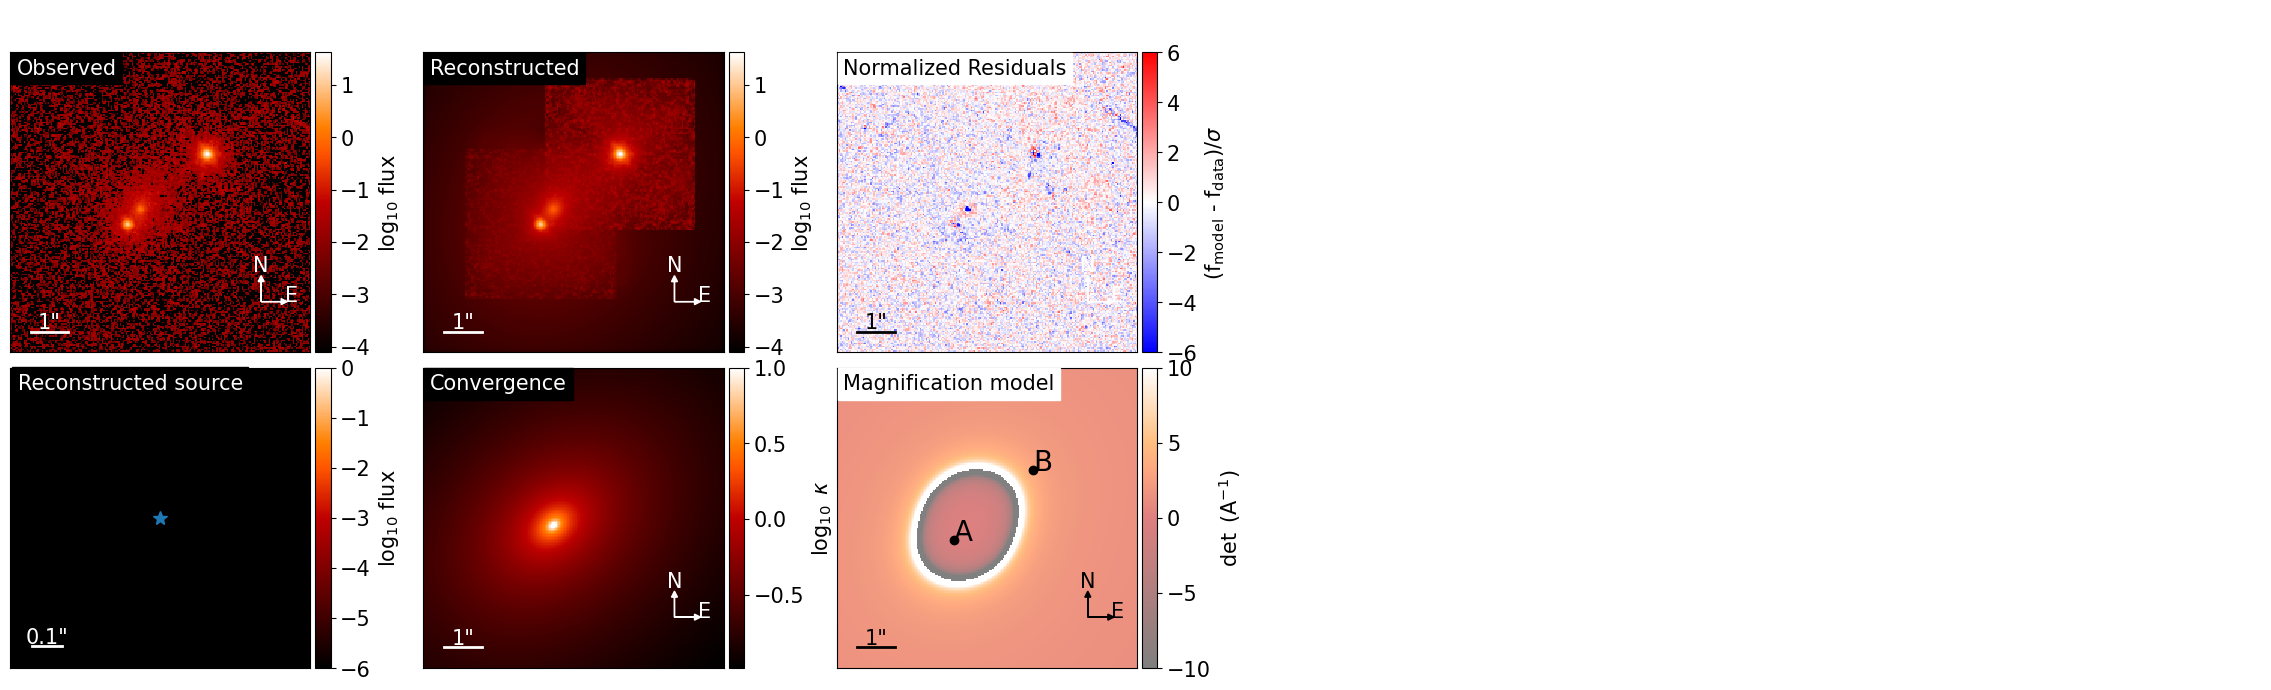

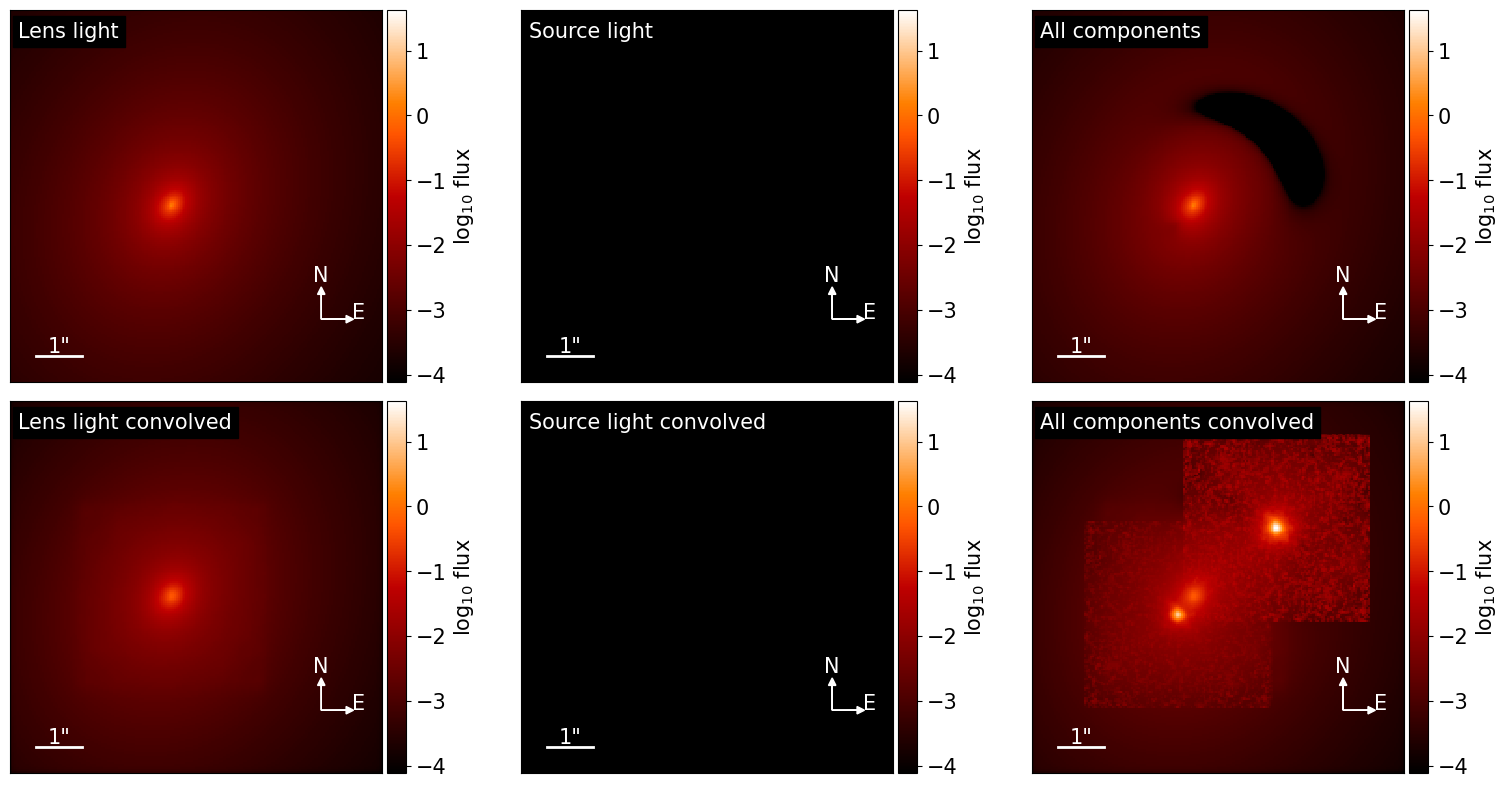

In [26]:
# we need to extract the updated multi_band_list object since the coordinate shifts were updated in the kwargs_data portions of it
multi_band_list_out = fitting_seq.multi_band_list

modelPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")

def plot_band(modelPlot, band_index_plot):
    """
    a set of plotting routines for a ModelPlot() instance with specified band
    """

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0,0], band_index=band_index_plot)
    modelPlot.model_plot(ax=axes[0,1], band_index=band_index_plot)
    modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_index_plot)
    modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100,  v_min=-6, v_max=0, band_index=band_index_plot)
    modelPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_index_plot)
    modelPlot.magnification_plot(ax=axes[1, 2], band_index=band_index_plot)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.decomposition_plot(ax=axes[0,0], band_index=band_index_plot, text='Lens light', lens_light_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,0], band_index=band_index_plot, text='Lens light convolved', lens_light_add=True)
    modelPlot.decomposition_plot(ax=axes[0,1], band_index=band_index_plot, text='Source light', source_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,1], band_index=band_index_plot, text='Source light convolved', source_add=True)
    modelPlot.decomposition_plot(ax=axes[0,2], band_index=band_index_plot, text='All components', source_add=True, lens_light_add=True, unconvolved=True)
    modelPlot.decomposition_plot(ax=axes[1,2], band_index=band_index_plot, text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
plot_band(modelPlot, band_index_plot=0)
plot_band(modelPlot, band_index_plot=1)
plot_band(modelPlot, band_index_plot=2)